In [57]:
from modeling import *
from som import SOM
from sklearn.preprocessing import MinMaxScaler

In [59]:
df = read_csv('features-BIDU-5y.csv')
df = prepare_df(df)

In [60]:
# dropping columns for training
df_prepared = df.drop(columns=[' High', ' Low', 'profit', 'close_plus_20_days', 'Date'])
df_train_columns = df_prepared.columns

In [61]:
# scaling data
scaler = MinMaxScaler()
df_prepared = scaler.fit_transform(df_prepared)

In [62]:
#splitting dataset into training and testing
train_len = len(df_prepared)-365
df_train = df_prepared[:train_len]
df_test = df_prepared[train_len:]

In [63]:
# fitting the model
som = SOM(10, 10)  
som.fit(df_train, 10000, save_e=True, interval=100)
som.plot_error_history(filename='../images/som_error.png')

Epoch 0;    Neuron [4, 4];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 1;    Neuron [5, 3];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 2;    Neuron [3, 1];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 3;    Neuron [0, 2];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 4;    Neuron [0, 8];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 5;    Neuron [4, 1];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 6;    Neuron [8, 7];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 7;    Neuron [7, 7];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 8;    Neuron [3, 2];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 9;    Neuron [8, 6];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 10;    Neuron [6, 4];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 11;    Neuron [8, 7];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 12;    Neuron [4, 3];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 13;    Neuron [1, 8];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 14;    Neuron [5, 6];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 15;    Neuron [9, 8];    	Sigma: 5.0000;    

Epoch 201;    Neuron [6, 8];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 202;    Neuron [7, 4];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 203;    Neuron [5, 8];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 204;    Neuron [5, 5];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 205;    Neuron [3, 9];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 206;    Neuron [0, 6];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 207;    Neuron [0, 2];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 208;    Neuron [1, 1];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 209;    Neuron [6, 4];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 210;    Neuron [4, 6];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 211;    Neuron [5, 6];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 212;    Neuron [4, 0];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 213;    Neuron [0, 1];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 214;    Neuron [9, 5];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 215;    Neuron [1, 5];    	Sigma: 5.0000;    alpha: 0.6000
Epoch 216;    Neuron [1, 

Epoch 401;    Neuron [7, 3];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 402;    Neuron [2, 4];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 403;    Neuron [6, 7];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 404;    Neuron [8, 1];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 405;    Neuron [1, 9];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 406;    Neuron [0, 4];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 407;    Neuron [5, 5];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 408;    Neuron [0, 8];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 409;    Neuron [3, 2];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 410;    Neuron [2, 1];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 411;    Neuron [9, 1];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 412;    Neuron [5, 5];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 413;    Neuron [6, 6];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 414;    Neuron [0, 6];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 415;    Neuron [5, 6];    	Sigma: 4.9998;    alpha: 0.6000
Epoch 416;    Neuron [2, 

Epoch 546;    Neuron [5, 4];    	Sigma: 4.9993;    alpha: 0.5999
Epoch 547;    Neuron [7, 8];    	Sigma: 4.9993;    alpha: 0.5999
Epoch 548;    Neuron [3, 5];    	Sigma: 4.9993;    alpha: 0.5999
Epoch 549;    Neuron [4, 5];    	Sigma: 4.9993;    alpha: 0.5999
Epoch 550;    Neuron [6, 3];    	Sigma: 4.9993;    alpha: 0.5999
Epoch 551;    Neuron [2, 9];    	Sigma: 4.9993;    alpha: 0.5999
Epoch 552;    Neuron [9, 3];    	Sigma: 4.9993;    alpha: 0.5999
Epoch 553;    Neuron [6, 4];    	Sigma: 4.9993;    alpha: 0.5999
Epoch 554;    Neuron [1, 0];    	Sigma: 4.9992;    alpha: 0.5999
Epoch 555;    Neuron [4, 8];    	Sigma: 4.9992;    alpha: 0.5999
Epoch 556;    Neuron [6, 4];    	Sigma: 4.9992;    alpha: 0.5999
Epoch 557;    Neuron [6, 4];    	Sigma: 4.9992;    alpha: 0.5999
Epoch 558;    Neuron [1, 9];    	Sigma: 4.9992;    alpha: 0.5999
Epoch 559;    Neuron [2, 2];    	Sigma: 4.9992;    alpha: 0.5999
Epoch 560;    Neuron [5, 7];    	Sigma: 4.9992;    alpha: 0.5999
Epoch 561;    Neuron [2, 

Epoch 701;    Neuron [2, 0];    	Sigma: 4.9981;    alpha: 0.5998
Epoch 702;    Neuron [4, 5];    	Sigma: 4.9981;    alpha: 0.5998
Epoch 703;    Neuron [9, 4];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 704;    Neuron [5, 8];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 705;    Neuron [4, 5];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 706;    Neuron [4, 3];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 707;    Neuron [0, 0];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 708;    Neuron [1, 9];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 709;    Neuron [0, 0];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 710;    Neuron [9, 6];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 711;    Neuron [2, 1];    	Sigma: 4.9980;    alpha: 0.5998
Epoch 712;    Neuron [6, 5];    	Sigma: 4.9979;    alpha: 0.5998
Epoch 713;    Neuron [9, 9];    	Sigma: 4.9979;    alpha: 0.5998
Epoch 714;    Neuron [4, 4];    	Sigma: 4.9979;    alpha: 0.5998
Epoch 715;    Neuron [7, 6];    	Sigma: 4.9979;    alpha: 0.5997
Epoch 716;    Neuron [6, 

Epoch 831;    Neuron [5, 0];    	Sigma: 4.9962;    alpha: 0.5995
Epoch 832;    Neuron [3, 3];    	Sigma: 4.9962;    alpha: 0.5995
Epoch 833;    Neuron [0, 8];    	Sigma: 4.9961;    alpha: 0.5995
Epoch 834;    Neuron [6, 2];    	Sigma: 4.9961;    alpha: 0.5995
Epoch 835;    Neuron [3, 6];    	Sigma: 4.9961;    alpha: 0.5995
Epoch 836;    Neuron [4, 7];    	Sigma: 4.9961;    alpha: 0.5995
Epoch 837;    Neuron [8, 5];    	Sigma: 4.9961;    alpha: 0.5995
Epoch 838;    Neuron [2, 5];    	Sigma: 4.9961;    alpha: 0.5995
Epoch 839;    Neuron [2, 5];    	Sigma: 4.9960;    alpha: 0.5995
Epoch 840;    Neuron [9, 3];    	Sigma: 4.9960;    alpha: 0.5995
Epoch 841;    Neuron [8, 2];    	Sigma: 4.9960;    alpha: 0.5995
Epoch 842;    Neuron [8, 4];    	Sigma: 4.9960;    alpha: 0.5995
Epoch 843;    Neuron [0, 9];    	Sigma: 4.9960;    alpha: 0.5995
Epoch 844;    Neuron [4, 1];    	Sigma: 4.9959;    alpha: 0.5995
Epoch 845;    Neuron [3, 8];    	Sigma: 4.9959;    alpha: 0.5995
Epoch 846;    Neuron [6, 

Epoch 1001;    Neuron [2, 7];    	Sigma: 4.9920;    alpha: 0.5990
Epoch 1002;    Neuron [4, 9];    	Sigma: 4.9919;    alpha: 0.5990
Epoch 1003;    Neuron [1, 9];    	Sigma: 4.9919;    alpha: 0.5990
Epoch 1004;    Neuron [1, 0];    	Sigma: 4.9919;    alpha: 0.5990
Epoch 1005;    Neuron [9, 2];    	Sigma: 4.9918;    alpha: 0.5990
Epoch 1006;    Neuron [4, 0];    	Sigma: 4.9918;    alpha: 0.5990
Epoch 1007;    Neuron [8, 4];    	Sigma: 4.9918;    alpha: 0.5990
Epoch 1008;    Neuron [5, 7];    	Sigma: 4.9918;    alpha: 0.5990
Epoch 1009;    Neuron [6, 5];    	Sigma: 4.9917;    alpha: 0.5990
Epoch 1010;    Neuron [3, 7];    	Sigma: 4.9917;    alpha: 0.5990
Epoch 1011;    Neuron [0, 2];    	Sigma: 4.9917;    alpha: 0.5990
Epoch 1012;    Neuron [6, 6];    	Sigma: 4.9916;    alpha: 0.5990
Epoch 1013;    Neuron [1, 1];    	Sigma: 4.9916;    alpha: 0.5990
Epoch 1014;    Neuron [4, 8];    	Sigma: 4.9916;    alpha: 0.5990
Epoch 1015;    Neuron [6, 9];    	Sigma: 4.9915;    alpha: 0.5990
Epoch 1016

Epoch 1201;    Neuron [2, 3];    	Sigma: 4.9834;    alpha: 0.5980
Epoch 1202;    Neuron [7, 5];    	Sigma: 4.9833;    alpha: 0.5980
Epoch 1203;    Neuron [5, 0];    	Sigma: 4.9833;    alpha: 0.5980
Epoch 1204;    Neuron [6, 2];    	Sigma: 4.9832;    alpha: 0.5980
Epoch 1205;    Neuron [3, 9];    	Sigma: 4.9832;    alpha: 0.5980
Epoch 1206;    Neuron [4, 4];    	Sigma: 4.9831;    alpha: 0.5980
Epoch 1207;    Neuron [7, 2];    	Sigma: 4.9831;    alpha: 0.5980
Epoch 1208;    Neuron [0, 5];    	Sigma: 4.9830;    alpha: 0.5980
Epoch 1209;    Neuron [3, 9];    	Sigma: 4.9830;    alpha: 0.5980
Epoch 1210;    Neuron [7, 8];    	Sigma: 4.9829;    alpha: 0.5979
Epoch 1211;    Neuron [1, 4];    	Sigma: 4.9828;    alpha: 0.5979
Epoch 1212;    Neuron [1, 3];    	Sigma: 4.9828;    alpha: 0.5979
Epoch 1213;    Neuron [9, 5];    	Sigma: 4.9827;    alpha: 0.5979
Epoch 1214;    Neuron [0, 5];    	Sigma: 4.9827;    alpha: 0.5979
Epoch 1215;    Neuron [5, 9];    	Sigma: 4.9826;    alpha: 0.5979
Epoch 1216

Epoch 1401;    Neuron [4, 2];    	Sigma: 4.9694;    alpha: 0.5963
Epoch 1402;    Neuron [0, 5];    	Sigma: 4.9693;    alpha: 0.5963
Epoch 1403;    Neuron [0, 4];    	Sigma: 4.9692;    alpha: 0.5963
Epoch 1404;    Neuron [4, 8];    	Sigma: 4.9691;    alpha: 0.5963
Epoch 1405;    Neuron [6, 8];    	Sigma: 4.9690;    alpha: 0.5963
Epoch 1406;    Neuron [4, 0];    	Sigma: 4.9689;    alpha: 0.5963
Epoch 1407;    Neuron [4, 8];    	Sigma: 4.9688;    alpha: 0.5963
Epoch 1408;    Neuron [9, 2];    	Sigma: 4.9687;    alpha: 0.5962
Epoch 1409;    Neuron [2, 5];    	Sigma: 4.9687;    alpha: 0.5962
Epoch 1410;    Neuron [1, 5];    	Sigma: 4.9686;    alpha: 0.5962
Epoch 1411;    Neuron [9, 1];    	Sigma: 4.9685;    alpha: 0.5962
Epoch 1412;    Neuron [1, 6];    	Sigma: 4.9684;    alpha: 0.5962
Epoch 1413;    Neuron [6, 4];    	Sigma: 4.9683;    alpha: 0.5962
Epoch 1414;    Neuron [6, 6];    	Sigma: 4.9682;    alpha: 0.5962
Epoch 1415;    Neuron [9, 3];    	Sigma: 4.9681;    alpha: 0.5962
Epoch 1416

Epoch 1601;    Neuron [8, 6];    	Sigma: 4.9480;    alpha: 0.5938
Epoch 1602;    Neuron [1, 2];    	Sigma: 4.9478;    alpha: 0.5937
Epoch 1603;    Neuron [6, 9];    	Sigma: 4.9477;    alpha: 0.5937
Epoch 1604;    Neuron [3, 4];    	Sigma: 4.9476;    alpha: 0.5937
Epoch 1605;    Neuron [8, 2];    	Sigma: 4.9474;    alpha: 0.5937
Epoch 1606;    Neuron [8, 3];    	Sigma: 4.9473;    alpha: 0.5937
Epoch 1607;    Neuron [3, 4];    	Sigma: 4.9472;    alpha: 0.5937
Epoch 1608;    Neuron [1, 0];    	Sigma: 4.9471;    alpha: 0.5936
Epoch 1609;    Neuron [9, 8];    	Sigma: 4.9469;    alpha: 0.5936
Epoch 1610;    Neuron [1, 6];    	Sigma: 4.9468;    alpha: 0.5936
Epoch 1611;    Neuron [4, 4];    	Sigma: 4.9467;    alpha: 0.5936
Epoch 1612;    Neuron [5, 7];    	Sigma: 4.9465;    alpha: 0.5936
Epoch 1613;    Neuron [3, 3];    	Sigma: 4.9464;    alpha: 0.5936
Epoch 1614;    Neuron [8, 9];    	Sigma: 4.9463;    alpha: 0.5936
Epoch 1615;    Neuron [8, 9];    	Sigma: 4.9461;    alpha: 0.5935
Epoch 1616

Epoch 1801;    Neuron [8, 3];    	Sigma: 4.9172;    alpha: 0.5901
Epoch 1802;    Neuron [4, 3];    	Sigma: 4.9170;    alpha: 0.5900
Epoch 1803;    Neuron [3, 7];    	Sigma: 4.9168;    alpha: 0.5900
Epoch 1804;    Neuron [4, 6];    	Sigma: 4.9166;    alpha: 0.5900
Epoch 1805;    Neuron [7, 8];    	Sigma: 4.9165;    alpha: 0.5900
Epoch 1806;    Neuron [5, 4];    	Sigma: 4.9163;    alpha: 0.5900
Epoch 1807;    Neuron [8, 3];    	Sigma: 4.9161;    alpha: 0.5899
Epoch 1808;    Neuron [2, 5];    	Sigma: 4.9159;    alpha: 0.5899
Epoch 1809;    Neuron [9, 9];    	Sigma: 4.9157;    alpha: 0.5899
Epoch 1810;    Neuron [4, 7];    	Sigma: 4.9156;    alpha: 0.5899
Epoch 1811;    Neuron [4, 5];    	Sigma: 4.9154;    alpha: 0.5898
Epoch 1812;    Neuron [1, 0];    	Sigma: 4.9152;    alpha: 0.5898
Epoch 1813;    Neuron [1, 0];    	Sigma: 4.9150;    alpha: 0.5898
Epoch 1814;    Neuron [7, 8];    	Sigma: 4.9148;    alpha: 0.5898
Epoch 1815;    Neuron [1, 1];    	Sigma: 4.9146;    alpha: 0.5898
Epoch 1816

Epoch 2001;    Neuron [6, 0];    	Sigma: 4.8749;    alpha: 0.5850
Epoch 2002;    Neuron [9, 3];    	Sigma: 4.8747;    alpha: 0.5850
Epoch 2003;    Neuron [3, 7];    	Sigma: 4.8744;    alpha: 0.5849
Epoch 2004;    Neuron [5, 0];    	Sigma: 4.8742;    alpha: 0.5849
Epoch 2005;    Neuron [4, 8];    	Sigma: 4.8739;    alpha: 0.5849
Epoch 2006;    Neuron [9, 1];    	Sigma: 4.8737;    alpha: 0.5848
Epoch 2007;    Neuron [7, 5];    	Sigma: 4.8734;    alpha: 0.5848
Epoch 2008;    Neuron [4, 0];    	Sigma: 4.8732;    alpha: 0.5848
Epoch 2009;    Neuron [0, 3];    	Sigma: 4.8729;    alpha: 0.5848
Epoch 2010;    Neuron [8, 5];    	Sigma: 4.8727;    alpha: 0.5847
Epoch 2011;    Neuron [9, 7];    	Sigma: 4.8724;    alpha: 0.5847
Epoch 2012;    Neuron [3, 8];    	Sigma: 4.8722;    alpha: 0.5847
Epoch 2013;    Neuron [8, 3];    	Sigma: 4.8720;    alpha: 0.5846
Epoch 2014;    Neuron [4, 0];    	Sigma: 4.8717;    alpha: 0.5846
Epoch 2015;    Neuron [3, 8];    	Sigma: 4.8715;    alpha: 0.5846
Epoch 2016

Epoch 2201;    Neuron [7, 5];    	Sigma: 4.8190;    alpha: 0.5783
Epoch 2202;    Neuron [5, 0];    	Sigma: 4.8187;    alpha: 0.5782
Epoch 2203;    Neuron [5, 1];    	Sigma: 4.8183;    alpha: 0.5782
Epoch 2204;    Neuron [3, 8];    	Sigma: 4.8180;    alpha: 0.5782
Epoch 2205;    Neuron [6, 1];    	Sigma: 4.8177;    alpha: 0.5781
Epoch 2206;    Neuron [9, 6];    	Sigma: 4.8174;    alpha: 0.5781
Epoch 2207;    Neuron [4, 2];    	Sigma: 4.8171;    alpha: 0.5780
Epoch 2208;    Neuron [1, 3];    	Sigma: 4.8167;    alpha: 0.5780
Epoch 2209;    Neuron [0, 8];    	Sigma: 4.8164;    alpha: 0.5780
Epoch 2210;    Neuron [8, 6];    	Sigma: 4.8161;    alpha: 0.5779
Epoch 2211;    Neuron [2, 8];    	Sigma: 4.8158;    alpha: 0.5779
Epoch 2212;    Neuron [5, 2];    	Sigma: 4.8155;    alpha: 0.5779
Epoch 2213;    Neuron [7, 3];    	Sigma: 4.8151;    alpha: 0.5778
Epoch 2214;    Neuron [5, 1];    	Sigma: 4.8148;    alpha: 0.5778
Epoch 2215;    Neuron [3, 7];    	Sigma: 4.8145;    alpha: 0.5777
Epoch 2216

Epoch 2401;    Neuron [8, 9];    	Sigma: 4.7475;    alpha: 0.5697
Epoch 2402;    Neuron [3, 4];    	Sigma: 4.7471;    alpha: 0.5696
Epoch 2403;    Neuron [9, 8];    	Sigma: 4.7467;    alpha: 0.5696
Epoch 2404;    Neuron [4, 0];    	Sigma: 4.7463;    alpha: 0.5696
Epoch 2405;    Neuron [9, 5];    	Sigma: 4.7459;    alpha: 0.5695
Epoch 2406;    Neuron [0, 0];    	Sigma: 4.7455;    alpha: 0.5695
Epoch 2407;    Neuron [3, 5];    	Sigma: 4.7451;    alpha: 0.5694
Epoch 2408;    Neuron [5, 3];    	Sigma: 4.7447;    alpha: 0.5694
Epoch 2409;    Neuron [7, 9];    	Sigma: 4.7443;    alpha: 0.5693
Epoch 2410;    Neuron [0, 1];    	Sigma: 4.7439;    alpha: 0.5693
Epoch 2411;    Neuron [0, 4];    	Sigma: 4.7434;    alpha: 0.5692
Epoch 2412;    Neuron [5, 4];    	Sigma: 4.7430;    alpha: 0.5692
Epoch 2413;    Neuron [4, 4];    	Sigma: 4.7426;    alpha: 0.5691
Epoch 2414;    Neuron [5, 6];    	Sigma: 4.7422;    alpha: 0.5691
Epoch 2415;    Neuron [0, 9];    	Sigma: 4.7418;    alpha: 0.5690
Epoch 2416

Epoch 2601;    Neuron [3, 3];    	Sigma: 4.6587;    alpha: 0.5590
Epoch 2602;    Neuron [1, 9];    	Sigma: 4.6582;    alpha: 0.5590
Epoch 2603;    Neuron [8, 7];    	Sigma: 4.6577;    alpha: 0.5589
Epoch 2604;    Neuron [4, 3];    	Sigma: 4.6572;    alpha: 0.5589
Epoch 2605;    Neuron [5, 9];    	Sigma: 4.6568;    alpha: 0.5588
Epoch 2606;    Neuron [0, 5];    	Sigma: 4.6563;    alpha: 0.5588
Epoch 2607;    Neuron [3, 1];    	Sigma: 4.6558;    alpha: 0.5587
Epoch 2608;    Neuron [5, 3];    	Sigma: 4.6553;    alpha: 0.5586
Epoch 2609;    Neuron [2, 0];    	Sigma: 4.6548;    alpha: 0.5586
Epoch 2610;    Neuron [3, 4];    	Sigma: 4.6543;    alpha: 0.5585
Epoch 2611;    Neuron [7, 8];    	Sigma: 4.6538;    alpha: 0.5585
Epoch 2612;    Neuron [0, 2];    	Sigma: 4.6533;    alpha: 0.5584
Epoch 2613;    Neuron [2, 2];    	Sigma: 4.6528;    alpha: 0.5583
Epoch 2614;    Neuron [4, 4];    	Sigma: 4.6523;    alpha: 0.5583
Epoch 2615;    Neuron [8, 8];    	Sigma: 4.6518;    alpha: 0.5582
Epoch 2616

Epoch 2801;    Neuron [3, 5];    	Sigma: 4.5516;    alpha: 0.5462
Epoch 2802;    Neuron [7, 9];    	Sigma: 4.5510;    alpha: 0.5461
Epoch 2803;    Neuron [4, 0];    	Sigma: 4.5504;    alpha: 0.5460
Epoch 2804;    Neuron [1, 4];    	Sigma: 4.5498;    alpha: 0.5460
Epoch 2805;    Neuron [1, 4];    	Sigma: 4.5492;    alpha: 0.5459
Epoch 2806;    Neuron [3, 3];    	Sigma: 4.5486;    alpha: 0.5458
Epoch 2807;    Neuron [8, 8];    	Sigma: 4.5481;    alpha: 0.5458
Epoch 2808;    Neuron [8, 8];    	Sigma: 4.5475;    alpha: 0.5457
Epoch 2809;    Neuron [1, 4];    	Sigma: 4.5469;    alpha: 0.5456
Epoch 2810;    Neuron [5, 9];    	Sigma: 4.5463;    alpha: 0.5456
Epoch 2811;    Neuron [7, 5];    	Sigma: 4.5457;    alpha: 0.5455
Epoch 2812;    Neuron [8, 9];    	Sigma: 4.5451;    alpha: 0.5454
Epoch 2813;    Neuron [5, 0];    	Sigma: 4.5445;    alpha: 0.5453
Epoch 2814;    Neuron [7, 3];    	Sigma: 4.5439;    alpha: 0.5453
Epoch 2815;    Neuron [9, 9];    	Sigma: 4.5433;    alpha: 0.5452
Epoch 2816

Epoch 2959;    Neuron [4, 4];    	Sigma: 4.4535;    alpha: 0.5344
Epoch 2960;    Neuron [7, 6];    	Sigma: 4.4529;    alpha: 0.5343
Epoch 2961;    Neuron [0, 0];    	Sigma: 4.4522;    alpha: 0.5343
Epoch 2962;    Neuron [9, 6];    	Sigma: 4.4515;    alpha: 0.5342
Epoch 2963;    Neuron [3, 4];    	Sigma: 4.4509;    alpha: 0.5341
Epoch 2964;    Neuron [1, 8];    	Sigma: 4.4502;    alpha: 0.5340
Epoch 2965;    Neuron [6, 1];    	Sigma: 4.4496;    alpha: 0.5339
Epoch 2966;    Neuron [6, 1];    	Sigma: 4.4489;    alpha: 0.5339
Epoch 2967;    Neuron [6, 4];    	Sigma: 4.4482;    alpha: 0.5338
Epoch 2968;    Neuron [6, 0];    	Sigma: 4.4476;    alpha: 0.5337
Epoch 2969;    Neuron [1, 8];    	Sigma: 4.4469;    alpha: 0.5336
Epoch 2970;    Neuron [3, 6];    	Sigma: 4.4463;    alpha: 0.5336
Epoch 2971;    Neuron [8, 8];    	Sigma: 4.4456;    alpha: 0.5335
Epoch 2972;    Neuron [0, 0];    	Sigma: 4.4449;    alpha: 0.5334
Epoch 2973;    Neuron [1, 0];    	Sigma: 4.4443;    alpha: 0.5333
Epoch 2974

Epoch 3086;    Neuron [7, 1];    	Sigma: 4.3662;    alpha: 0.5239
Epoch 3087;    Neuron [2, 7];    	Sigma: 4.3654;    alpha: 0.5239
Epoch 3088;    Neuron [3, 5];    	Sigma: 4.3647;    alpha: 0.5238
Epoch 3089;    Neuron [4, 5];    	Sigma: 4.3640;    alpha: 0.5237
Epoch 3090;    Neuron [0, 7];    	Sigma: 4.3633;    alpha: 0.5236
Epoch 3091;    Neuron [3, 5];    	Sigma: 4.3626;    alpha: 0.5235
Epoch 3092;    Neuron [8, 2];    	Sigma: 4.3619;    alpha: 0.5234
Epoch 3093;    Neuron [3, 4];    	Sigma: 4.3611;    alpha: 0.5233
Epoch 3094;    Neuron [3, 2];    	Sigma: 4.3604;    alpha: 0.5232
Epoch 3095;    Neuron [5, 0];    	Sigma: 4.3597;    alpha: 0.5232
Epoch 3096;    Neuron [5, 5];    	Sigma: 4.3590;    alpha: 0.5231
Epoch 3097;    Neuron [8, 1];    	Sigma: 4.3582;    alpha: 0.5230
Epoch 3098;    Neuron [0, 7];    	Sigma: 4.3575;    alpha: 0.5229
Epoch 3099;    Neuron [3, 6];    	Sigma: 4.3568;    alpha: 0.5228
Epoch 3100;    Neuron [3, 4];    	Sigma: 4.3561;    alpha: 0.5227
Epoch 3101

Epoch 3236;    Neuron [1, 2];    	Sigma: 4.2534;    alpha: 0.5104
Epoch 3237;    Neuron [4, 6];    	Sigma: 4.2526;    alpha: 0.5103
Epoch 3238;    Neuron [6, 1];    	Sigma: 4.2519;    alpha: 0.5102
Epoch 3239;    Neuron [2, 6];    	Sigma: 4.2511;    alpha: 0.5101
Epoch 3240;    Neuron [8, 6];    	Sigma: 4.2503;    alpha: 0.5100
Epoch 3241;    Neuron [5, 9];    	Sigma: 4.2495;    alpha: 0.5099
Epoch 3242;    Neuron [9, 2];    	Sigma: 4.2487;    alpha: 0.5098
Epoch 3243;    Neuron [1, 6];    	Sigma: 4.2479;    alpha: 0.5098
Epoch 3244;    Neuron [0, 6];    	Sigma: 4.2471;    alpha: 0.5097
Epoch 3245;    Neuron [7, 4];    	Sigma: 4.2464;    alpha: 0.5096
Epoch 3246;    Neuron [4, 4];    	Sigma: 4.2456;    alpha: 0.5095
Epoch 3247;    Neuron [0, 4];    	Sigma: 4.2448;    alpha: 0.5094
Epoch 3248;    Neuron [4, 9];    	Sigma: 4.2440;    alpha: 0.5093
Epoch 3249;    Neuron [1, 3];    	Sigma: 4.2432;    alpha: 0.5092
Epoch 3250;    Neuron [6, 1];    	Sigma: 4.2424;    alpha: 0.5091
Epoch 3251

Epoch 3401;    Neuron [0, 0];    	Sigma: 4.1181;    alpha: 0.4942
Epoch 3402;    Neuron [4, 8];    	Sigma: 4.1172;    alpha: 0.4941
Epoch 3403;    Neuron [6, 8];    	Sigma: 4.1164;    alpha: 0.4940
Epoch 3404;    Neuron [0, 6];    	Sigma: 4.1155;    alpha: 0.4939
Epoch 3405;    Neuron [1, 1];    	Sigma: 4.1147;    alpha: 0.4938
Epoch 3406;    Neuron [1, 4];    	Sigma: 4.1138;    alpha: 0.4937
Epoch 3407;    Neuron [0, 1];    	Sigma: 4.1130;    alpha: 0.4936
Epoch 3408;    Neuron [4, 6];    	Sigma: 4.1121;    alpha: 0.4935
Epoch 3409;    Neuron [4, 5];    	Sigma: 4.1113;    alpha: 0.4934
Epoch 3410;    Neuron [8, 9];    	Sigma: 4.1104;    alpha: 0.4932
Epoch 3411;    Neuron [1, 1];    	Sigma: 4.1095;    alpha: 0.4931
Epoch 3412;    Neuron [5, 9];    	Sigma: 4.1087;    alpha: 0.4930
Epoch 3413;    Neuron [9, 0];    	Sigma: 4.1078;    alpha: 0.4929
Epoch 3414;    Neuron [6, 0];    	Sigma: 4.1070;    alpha: 0.4928
Epoch 3415;    Neuron [5, 7];    	Sigma: 4.1061;    alpha: 0.4927
Epoch 3416

Epoch 3568;    Neuron [3, 7];    	Sigma: 3.9701;    alpha: 0.4764
Epoch 3569;    Neuron [9, 0];    	Sigma: 3.9692;    alpha: 0.4763
Epoch 3570;    Neuron [1, 4];    	Sigma: 3.9683;    alpha: 0.4762
Epoch 3571;    Neuron [7, 4];    	Sigma: 3.9673;    alpha: 0.4761
Epoch 3572;    Neuron [4, 0];    	Sigma: 3.9664;    alpha: 0.4760
Epoch 3573;    Neuron [0, 7];    	Sigma: 3.9655;    alpha: 0.4759
Epoch 3574;    Neuron [6, 4];    	Sigma: 3.9646;    alpha: 0.4758
Epoch 3575;    Neuron [2, 0];    	Sigma: 3.9637;    alpha: 0.4756
Epoch 3576;    Neuron [4, 8];    	Sigma: 3.9628;    alpha: 0.4755
Epoch 3577;    Neuron [1, 5];    	Sigma: 3.9618;    alpha: 0.4754
Epoch 3578;    Neuron [7, 4];    	Sigma: 3.9609;    alpha: 0.4753
Epoch 3579;    Neuron [7, 5];    	Sigma: 3.9600;    alpha: 0.4752
Epoch 3580;    Neuron [9, 7];    	Sigma: 3.9591;    alpha: 0.4751
Epoch 3581;    Neuron [0, 0];    	Sigma: 3.9582;    alpha: 0.4750
Epoch 3582;    Neuron [9, 9];    	Sigma: 3.9572;    alpha: 0.4749
Epoch 3583

Epoch 3701;    Neuron [9, 4];    	Sigma: 3.8452;    alpha: 0.4614
Epoch 3702;    Neuron [2, 5];    	Sigma: 3.8443;    alpha: 0.4613
Epoch 3703;    Neuron [2, 4];    	Sigma: 3.8433;    alpha: 0.4612
Epoch 3704;    Neuron [6, 0];    	Sigma: 3.8424;    alpha: 0.4611
Epoch 3705;    Neuron [8, 0];    	Sigma: 3.8414;    alpha: 0.4610
Epoch 3706;    Neuron [8, 3];    	Sigma: 3.8404;    alpha: 0.4609
Epoch 3707;    Neuron [5, 5];    	Sigma: 3.8395;    alpha: 0.4607
Epoch 3708;    Neuron [5, 7];    	Sigma: 3.8385;    alpha: 0.4606
Epoch 3709;    Neuron [1, 9];    	Sigma: 3.8375;    alpha: 0.4605
Epoch 3710;    Neuron [7, 2];    	Sigma: 3.8366;    alpha: 0.4604
Epoch 3711;    Neuron [3, 7];    	Sigma: 3.8356;    alpha: 0.4603
Epoch 3712;    Neuron [0, 0];    	Sigma: 3.8347;    alpha: 0.4602
Epoch 3713;    Neuron [7, 6];    	Sigma: 3.8337;    alpha: 0.4600
Epoch 3714;    Neuron [0, 0];    	Sigma: 3.8327;    alpha: 0.4599
Epoch 3715;    Neuron [7, 3];    	Sigma: 3.8318;    alpha: 0.4598
Epoch 3716

Epoch 3860;    Neuron [4, 8];    	Sigma: 3.6891;    alpha: 0.4427
Epoch 3861;    Neuron [0, 0];    	Sigma: 3.6881;    alpha: 0.4426
Epoch 3862;    Neuron [5, 7];    	Sigma: 3.6871;    alpha: 0.4425
Epoch 3863;    Neuron [5, 4];    	Sigma: 3.6861;    alpha: 0.4423
Epoch 3864;    Neuron [8, 1];    	Sigma: 3.6851;    alpha: 0.4422
Epoch 3865;    Neuron [3, 3];    	Sigma: 3.6841;    alpha: 0.4421
Epoch 3866;    Neuron [4, 9];    	Sigma: 3.6831;    alpha: 0.4420
Epoch 3867;    Neuron [7, 2];    	Sigma: 3.6821;    alpha: 0.4419
Epoch 3868;    Neuron [5, 3];    	Sigma: 3.6811;    alpha: 0.4417
Epoch 3869;    Neuron [1, 2];    	Sigma: 3.6801;    alpha: 0.4416
Epoch 3870;    Neuron [8, 2];    	Sigma: 3.6791;    alpha: 0.4415
Epoch 3871;    Neuron [9, 1];    	Sigma: 3.6781;    alpha: 0.4414
Epoch 3872;    Neuron [9, 5];    	Sigma: 3.6771;    alpha: 0.4412
Epoch 3873;    Neuron [4, 6];    	Sigma: 3.6761;    alpha: 0.4411
Epoch 3874;    Neuron [5, 8];    	Sigma: 3.6751;    alpha: 0.4410
Epoch 3875

Epoch 4001;    Neuron [3, 6];    	Sigma: 3.5457;    alpha: 0.4255
Epoch 4002;    Neuron [7, 8];    	Sigma: 3.5446;    alpha: 0.4254
Epoch 4003;    Neuron [9, 2];    	Sigma: 3.5436;    alpha: 0.4252
Epoch 4004;    Neuron [2, 2];    	Sigma: 3.5426;    alpha: 0.4251
Epoch 4005;    Neuron [5, 4];    	Sigma: 3.5415;    alpha: 0.4250
Epoch 4006;    Neuron [6, 3];    	Sigma: 3.5405;    alpha: 0.4249
Epoch 4007;    Neuron [1, 2];    	Sigma: 3.5395;    alpha: 0.4247
Epoch 4008;    Neuron [9, 2];    	Sigma: 3.5384;    alpha: 0.4246
Epoch 4009;    Neuron [5, 8];    	Sigma: 3.5374;    alpha: 0.4245
Epoch 4010;    Neuron [9, 0];    	Sigma: 3.5364;    alpha: 0.4244
Epoch 4011;    Neuron [0, 1];    	Sigma: 3.5353;    alpha: 0.4242
Epoch 4012;    Neuron [2, 6];    	Sigma: 3.5343;    alpha: 0.4241
Epoch 4013;    Neuron [4, 7];    	Sigma: 3.5333;    alpha: 0.4240
Epoch 4014;    Neuron [0, 5];    	Sigma: 3.5322;    alpha: 0.4239
Epoch 4015;    Neuron [7, 7];    	Sigma: 3.5312;    alpha: 0.4237
Epoch 4016

Epoch 4132;    Neuron [6, 5];    	Sigma: 3.4093;    alpha: 0.4091
Epoch 4133;    Neuron [3, 7];    	Sigma: 3.4082;    alpha: 0.4090
Epoch 4134;    Neuron [9, 3];    	Sigma: 3.4072;    alpha: 0.4089
Epoch 4135;    Neuron [4, 0];    	Sigma: 3.4061;    alpha: 0.4087
Epoch 4136;    Neuron [0, 5];    	Sigma: 3.4051;    alpha: 0.4086
Epoch 4137;    Neuron [4, 6];    	Sigma: 3.4040;    alpha: 0.4085
Epoch 4138;    Neuron [6, 4];    	Sigma: 3.4030;    alpha: 0.4084
Epoch 4139;    Neuron [4, 8];    	Sigma: 3.4019;    alpha: 0.4082
Epoch 4140;    Neuron [7, 7];    	Sigma: 3.4009;    alpha: 0.4081
Epoch 4141;    Neuron [9, 2];    	Sigma: 3.3998;    alpha: 0.4080
Epoch 4142;    Neuron [8, 8];    	Sigma: 3.3988;    alpha: 0.4079
Epoch 4143;    Neuron [2, 0];    	Sigma: 3.3977;    alpha: 0.4077
Epoch 4144;    Neuron [4, 8];    	Sigma: 3.3967;    alpha: 0.4076
Epoch 4145;    Neuron [5, 0];    	Sigma: 3.3956;    alpha: 0.4075
Epoch 4146;    Neuron [1, 6];    	Sigma: 3.3946;    alpha: 0.4073
Epoch 4147

Epoch 4301;    Neuron [9, 3];    	Sigma: 3.2305;    alpha: 0.3877
Epoch 4302;    Neuron [2, 8];    	Sigma: 3.2295;    alpha: 0.3875
Epoch 4303;    Neuron [2, 5];    	Sigma: 3.2284;    alpha: 0.3874
Epoch 4304;    Neuron [4, 5];    	Sigma: 3.2273;    alpha: 0.3873
Epoch 4305;    Neuron [8, 9];    	Sigma: 3.2263;    alpha: 0.3872
Epoch 4306;    Neuron [8, 6];    	Sigma: 3.2252;    alpha: 0.3870
Epoch 4307;    Neuron [0, 2];    	Sigma: 3.2241;    alpha: 0.3869
Epoch 4308;    Neuron [7, 9];    	Sigma: 3.2231;    alpha: 0.3868
Epoch 4309;    Neuron [3, 0];    	Sigma: 3.2220;    alpha: 0.3866
Epoch 4310;    Neuron [2, 3];    	Sigma: 3.2210;    alpha: 0.3865
Epoch 4311;    Neuron [3, 1];    	Sigma: 3.2199;    alpha: 0.3864
Epoch 4312;    Neuron [8, 1];    	Sigma: 3.2188;    alpha: 0.3863
Epoch 4313;    Neuron [8, 6];    	Sigma: 3.2178;    alpha: 0.3861
Epoch 4314;    Neuron [2, 5];    	Sigma: 3.2167;    alpha: 0.3860
Epoch 4315;    Neuron [5, 9];    	Sigma: 3.2156;    alpha: 0.3859
Epoch 4316

Epoch 4455;    Neuron [5, 3];    	Sigma: 3.0665;    alpha: 0.3680
Epoch 4456;    Neuron [1, 9];    	Sigma: 3.0655;    alpha: 0.3679
Epoch 4457;    Neuron [4, 0];    	Sigma: 3.0644;    alpha: 0.3677
Epoch 4458;    Neuron [4, 8];    	Sigma: 3.0634;    alpha: 0.3676
Epoch 4459;    Neuron [1, 5];    	Sigma: 3.0623;    alpha: 0.3675
Epoch 4460;    Neuron [9, 8];    	Sigma: 3.0612;    alpha: 0.3673
Epoch 4461;    Neuron [2, 3];    	Sigma: 3.0602;    alpha: 0.3672
Epoch 4462;    Neuron [8, 3];    	Sigma: 3.0591;    alpha: 0.3671
Epoch 4463;    Neuron [9, 0];    	Sigma: 3.0580;    alpha: 0.3670
Epoch 4464;    Neuron [6, 8];    	Sigma: 3.0570;    alpha: 0.3668
Epoch 4465;    Neuron [2, 4];    	Sigma: 3.0559;    alpha: 0.3667
Epoch 4466;    Neuron [0, 8];    	Sigma: 3.0548;    alpha: 0.3666
Epoch 4467;    Neuron [6, 9];    	Sigma: 3.0538;    alpha: 0.3665
Epoch 4468;    Neuron [2, 7];    	Sigma: 3.0527;    alpha: 0.3663
Epoch 4469;    Neuron [4, 0];    	Sigma: 3.0516;    alpha: 0.3662
Epoch 4470

Epoch 4601;    Neuron [8, 3];    	Sigma: 2.9115;    alpha: 0.3494
Epoch 4602;    Neuron [8, 2];    	Sigma: 2.9105;    alpha: 0.3493
Epoch 4603;    Neuron [3, 9];    	Sigma: 2.9094;    alpha: 0.3491
Epoch 4604;    Neuron [2, 2];    	Sigma: 2.9084;    alpha: 0.3490
Epoch 4605;    Neuron [6, 0];    	Sigma: 2.9073;    alpha: 0.3489
Epoch 4606;    Neuron [0, 0];    	Sigma: 2.9063;    alpha: 0.3488
Epoch 4607;    Neuron [3, 9];    	Sigma: 2.9052;    alpha: 0.3486
Epoch 4608;    Neuron [1, 0];    	Sigma: 2.9041;    alpha: 0.3485
Epoch 4609;    Neuron [0, 5];    	Sigma: 2.9031;    alpha: 0.3484
Epoch 4610;    Neuron [6, 1];    	Sigma: 2.9020;    alpha: 0.3482
Epoch 4611;    Neuron [3, 8];    	Sigma: 2.9010;    alpha: 0.3481
Epoch 4612;    Neuron [4, 2];    	Sigma: 2.8999;    alpha: 0.3480
Epoch 4613;    Neuron [5, 2];    	Sigma: 2.8989;    alpha: 0.3479
Epoch 4614;    Neuron [5, 8];    	Sigma: 2.8978;    alpha: 0.3477
Epoch 4615;    Neuron [0, 7];    	Sigma: 2.8967;    alpha: 0.3476
Epoch 4616

Epoch 4767;    Neuron [2, 9];    	Sigma: 2.7374;    alpha: 0.3285
Epoch 4768;    Neuron [6, 0];    	Sigma: 2.7363;    alpha: 0.3284
Epoch 4769;    Neuron [1, 9];    	Sigma: 2.7353;    alpha: 0.3282
Epoch 4770;    Neuron [1, 4];    	Sigma: 2.7343;    alpha: 0.3281
Epoch 4771;    Neuron [2, 0];    	Sigma: 2.7332;    alpha: 0.3280
Epoch 4772;    Neuron [0, 8];    	Sigma: 2.7322;    alpha: 0.3279
Epoch 4773;    Neuron [0, 1];    	Sigma: 2.7312;    alpha: 0.3277
Epoch 4774;    Neuron [2, 1];    	Sigma: 2.7301;    alpha: 0.3276
Epoch 4775;    Neuron [1, 4];    	Sigma: 2.7291;    alpha: 0.3275
Epoch 4776;    Neuron [9, 2];    	Sigma: 2.7280;    alpha: 0.3274
Epoch 4777;    Neuron [0, 6];    	Sigma: 2.7270;    alpha: 0.3272
Epoch 4778;    Neuron [3, 3];    	Sigma: 2.7260;    alpha: 0.3271
Epoch 4779;    Neuron [8, 4];    	Sigma: 2.7249;    alpha: 0.3270
Epoch 4780;    Neuron [6, 7];    	Sigma: 2.7239;    alpha: 0.3269
Epoch 4781;    Neuron [3, 3];    	Sigma: 2.7228;    alpha: 0.3267
Epoch 4782

Epoch 4894;    Neuron [6, 2];    	Sigma: 2.6066;    alpha: 0.3128
Epoch 4895;    Neuron [7, 2];    	Sigma: 2.6056;    alpha: 0.3127
Epoch 4896;    Neuron [0, 0];    	Sigma: 2.6045;    alpha: 0.3125
Epoch 4897;    Neuron [9, 1];    	Sigma: 2.6035;    alpha: 0.3124
Epoch 4898;    Neuron [1, 4];    	Sigma: 2.6025;    alpha: 0.3123
Epoch 4899;    Neuron [5, 7];    	Sigma: 2.6015;    alpha: 0.3122
Epoch 4900;    Neuron [3, 7];    	Sigma: 2.6005;    alpha: 0.3121
Epoch 4901;    Neuron [2, 0];    	Sigma: 2.5994;    alpha: 0.3119
Epoch 4902;    Neuron [9, 6];    	Sigma: 2.5984;    alpha: 0.3118
Epoch 4903;    Neuron [1, 3];    	Sigma: 2.5974;    alpha: 0.3117
Epoch 4904;    Neuron [3, 0];    	Sigma: 2.5964;    alpha: 0.3116
Epoch 4905;    Neuron [0, 8];    	Sigma: 2.5954;    alpha: 0.3114
Epoch 4906;    Neuron [4, 4];    	Sigma: 2.5943;    alpha: 0.3113
Epoch 4907;    Neuron [6, 1];    	Sigma: 2.5933;    alpha: 0.3112
Epoch 4908;    Neuron [7, 8];    	Sigma: 2.5923;    alpha: 0.3111
Epoch 4909

Epoch 5081;    Neuron [9, 2];    	Sigma: 2.4192;    alpha: 0.2903
Epoch 5082;    Neuron [3, 1];    	Sigma: 2.4182;    alpha: 0.2902
Epoch 5083;    Neuron [9, 7];    	Sigma: 2.4172;    alpha: 0.2901
Epoch 5084;    Neuron [7, 0];    	Sigma: 2.4162;    alpha: 0.2899
Epoch 5085;    Neuron [7, 5];    	Sigma: 2.4152;    alpha: 0.2898
Epoch 5086;    Neuron [7, 0];    	Sigma: 2.4143;    alpha: 0.2897
Epoch 5087;    Neuron [1, 7];    	Sigma: 2.4133;    alpha: 0.2896
Epoch 5088;    Neuron [0, 0];    	Sigma: 2.4123;    alpha: 0.2895
Epoch 5089;    Neuron [9, 5];    	Sigma: 2.4113;    alpha: 0.2894
Epoch 5090;    Neuron [0, 6];    	Sigma: 2.4103;    alpha: 0.2892
Epoch 5091;    Neuron [7, 8];    	Sigma: 2.4094;    alpha: 0.2891
Epoch 5092;    Neuron [1, 9];    	Sigma: 2.4084;    alpha: 0.2890
Epoch 5093;    Neuron [3, 9];    	Sigma: 2.4074;    alpha: 0.2889
Epoch 5094;    Neuron [4, 9];    	Sigma: 2.4064;    alpha: 0.2888
Epoch 5095;    Neuron [3, 4];    	Sigma: 2.4054;    alpha: 0.2887
Epoch 5096

Epoch 5235;    Neuron [4, 1];    	Sigma: 2.2705;    alpha: 0.2725
Epoch 5236;    Neuron [5, 9];    	Sigma: 2.2696;    alpha: 0.2723
Epoch 5237;    Neuron [7, 1];    	Sigma: 2.2686;    alpha: 0.2722
Epoch 5238;    Neuron [1, 6];    	Sigma: 2.2677;    alpha: 0.2721
Epoch 5239;    Neuron [0, 8];    	Sigma: 2.2667;    alpha: 0.2720
Epoch 5240;    Neuron [9, 4];    	Sigma: 2.2658;    alpha: 0.2719
Epoch 5241;    Neuron [8, 1];    	Sigma: 2.2648;    alpha: 0.2718
Epoch 5242;    Neuron [2, 6];    	Sigma: 2.2639;    alpha: 0.2717
Epoch 5243;    Neuron [1, 3];    	Sigma: 2.2629;    alpha: 0.2716
Epoch 5244;    Neuron [3, 5];    	Sigma: 2.2620;    alpha: 0.2714
Epoch 5245;    Neuron [2, 4];    	Sigma: 2.2610;    alpha: 0.2713
Epoch 5246;    Neuron [4, 0];    	Sigma: 2.2601;    alpha: 0.2712
Epoch 5247;    Neuron [2, 3];    	Sigma: 2.2592;    alpha: 0.2711
Epoch 5248;    Neuron [2, 2];    	Sigma: 2.2582;    alpha: 0.2710
Epoch 5249;    Neuron [7, 9];    	Sigma: 2.2573;    alpha: 0.2709
Epoch 5250

Epoch 5401;    Neuron [7, 3];    	Sigma: 2.1168;    alpha: 0.2540
Epoch 5402;    Neuron [3, 7];    	Sigma: 2.1159;    alpha: 0.2539
Epoch 5403;    Neuron [3, 4];    	Sigma: 2.1150;    alpha: 0.2538
Epoch 5404;    Neuron [1, 9];    	Sigma: 2.1141;    alpha: 0.2537
Epoch 5405;    Neuron [0, 8];    	Sigma: 2.1132;    alpha: 0.2536
Epoch 5406;    Neuron [4, 5];    	Sigma: 2.1123;    alpha: 0.2535
Epoch 5407;    Neuron [7, 0];    	Sigma: 2.1114;    alpha: 0.2534
Epoch 5408;    Neuron [4, 1];    	Sigma: 2.1105;    alpha: 0.2533
Epoch 5409;    Neuron [1, 3];    	Sigma: 2.1096;    alpha: 0.2532
Epoch 5410;    Neuron [8, 9];    	Sigma: 2.1087;    alpha: 0.2530
Epoch 5411;    Neuron [8, 5];    	Sigma: 2.1078;    alpha: 0.2529
Epoch 5412;    Neuron [3, 2];    	Sigma: 2.1069;    alpha: 0.2528
Epoch 5413;    Neuron [1, 3];    	Sigma: 2.1060;    alpha: 0.2527
Epoch 5414;    Neuron [7, 1];    	Sigma: 2.1051;    alpha: 0.2526
Epoch 5415;    Neuron [1, 3];    	Sigma: 2.1042;    alpha: 0.2525
Epoch 5416

Epoch 5552;    Neuron [4, 7];    	Sigma: 1.9834;    alpha: 0.2380
Epoch 5553;    Neuron [9, 8];    	Sigma: 1.9826;    alpha: 0.2379
Epoch 5554;    Neuron [5, 8];    	Sigma: 1.9817;    alpha: 0.2378
Epoch 5555;    Neuron [7, 6];    	Sigma: 1.9809;    alpha: 0.2377
Epoch 5556;    Neuron [0, 3];    	Sigma: 1.9800;    alpha: 0.2376
Epoch 5557;    Neuron [0, 2];    	Sigma: 1.9791;    alpha: 0.2375
Epoch 5558;    Neuron [8, 3];    	Sigma: 1.9783;    alpha: 0.2374
Epoch 5559;    Neuron [2, 3];    	Sigma: 1.9774;    alpha: 0.2373
Epoch 5560;    Neuron [7, 2];    	Sigma: 1.9766;    alpha: 0.2372
Epoch 5561;    Neuron [5, 8];    	Sigma: 1.9757;    alpha: 0.2371
Epoch 5562;    Neuron [4, 9];    	Sigma: 1.9748;    alpha: 0.2370
Epoch 5563;    Neuron [3, 6];    	Sigma: 1.9740;    alpha: 0.2369
Epoch 5564;    Neuron [1, 8];    	Sigma: 1.9731;    alpha: 0.2368
Epoch 5565;    Neuron [9, 1];    	Sigma: 1.9723;    alpha: 0.2367
Epoch 5566;    Neuron [6, 3];    	Sigma: 1.9714;    alpha: 0.2366
Epoch 5567

Epoch 5701;    Neuron [2, 3];    	Sigma: 1.8582;    alpha: 0.2230
Epoch 5702;    Neuron [3, 3];    	Sigma: 1.8573;    alpha: 0.2229
Epoch 5703;    Neuron [0, 3];    	Sigma: 1.8565;    alpha: 0.2228
Epoch 5704;    Neuron [6, 8];    	Sigma: 1.8557;    alpha: 0.2227
Epoch 5705;    Neuron [8, 9];    	Sigma: 1.8549;    alpha: 0.2226
Epoch 5706;    Neuron [4, 8];    	Sigma: 1.8541;    alpha: 0.2225
Epoch 5707;    Neuron [2, 4];    	Sigma: 1.8533;    alpha: 0.2224
Epoch 5708;    Neuron [9, 2];    	Sigma: 1.8524;    alpha: 0.2223
Epoch 5709;    Neuron [1, 3];    	Sigma: 1.8516;    alpha: 0.2222
Epoch 5710;    Neuron [8, 4];    	Sigma: 1.8508;    alpha: 0.2221
Epoch 5711;    Neuron [1, 9];    	Sigma: 1.8500;    alpha: 0.2220
Epoch 5712;    Neuron [8, 7];    	Sigma: 1.8492;    alpha: 0.2219
Epoch 5713;    Neuron [4, 9];    	Sigma: 1.8484;    alpha: 0.2218
Epoch 5714;    Neuron [1, 8];    	Sigma: 1.8475;    alpha: 0.2217
Epoch 5715;    Neuron [1, 1];    	Sigma: 1.8467;    alpha: 0.2216
Epoch 5716

Epoch 5831;    Neuron [3, 8];    	Sigma: 1.7541;    alpha: 0.2105
Epoch 5832;    Neuron [2, 3];    	Sigma: 1.7534;    alpha: 0.2104
Epoch 5833;    Neuron [7, 1];    	Sigma: 1.7526;    alpha: 0.2103
Epoch 5834;    Neuron [8, 6];    	Sigma: 1.7518;    alpha: 0.2102
Epoch 5835;    Neuron [2, 0];    	Sigma: 1.7510;    alpha: 0.2101
Epoch 5836;    Neuron [9, 6];    	Sigma: 1.7502;    alpha: 0.2100
Epoch 5837;    Neuron [3, 1];    	Sigma: 1.7495;    alpha: 0.2099
Epoch 5838;    Neuron [3, 4];    	Sigma: 1.7487;    alpha: 0.2098
Epoch 5839;    Neuron [0, 8];    	Sigma: 1.7479;    alpha: 0.2097
Epoch 5840;    Neuron [8, 5];    	Sigma: 1.7471;    alpha: 0.2097
Epoch 5841;    Neuron [6, 3];    	Sigma: 1.7463;    alpha: 0.2096
Epoch 5842;    Neuron [4, 3];    	Sigma: 1.7456;    alpha: 0.2095
Epoch 5843;    Neuron [4, 0];    	Sigma: 1.7448;    alpha: 0.2094
Epoch 5844;    Neuron [3, 5];    	Sigma: 1.7440;    alpha: 0.2093
Epoch 5845;    Neuron [5, 0];    	Sigma: 1.7432;    alpha: 0.2092
Epoch 5846

Epoch 5963;    Neuron [5, 9];    	Sigma: 1.6536;    alpha: 0.1984
Epoch 5964;    Neuron [8, 9];    	Sigma: 1.6528;    alpha: 0.1983
Epoch 5965;    Neuron [5, 4];    	Sigma: 1.6521;    alpha: 0.1983
Epoch 5966;    Neuron [4, 1];    	Sigma: 1.6514;    alpha: 0.1982
Epoch 5967;    Neuron [5, 9];    	Sigma: 1.6506;    alpha: 0.1981
Epoch 5968;    Neuron [3, 5];    	Sigma: 1.6499;    alpha: 0.1980
Epoch 5969;    Neuron [8, 5];    	Sigma: 1.6491;    alpha: 0.1979
Epoch 5970;    Neuron [3, 6];    	Sigma: 1.6484;    alpha: 0.1978
Epoch 5971;    Neuron [8, 3];    	Sigma: 1.6477;    alpha: 0.1977
Epoch 5972;    Neuron [5, 2];    	Sigma: 1.6469;    alpha: 0.1976
Epoch 5973;    Neuron [5, 9];    	Sigma: 1.6462;    alpha: 0.1975
Epoch 5974;    Neuron [7, 1];    	Sigma: 1.6454;    alpha: 0.1975
Epoch 5975;    Neuron [8, 9];    	Sigma: 1.6447;    alpha: 0.1974
Epoch 5976;    Neuron [1, 0];    	Sigma: 1.6440;    alpha: 0.1973
Epoch 5977;    Neuron [9, 2];    	Sigma: 1.6432;    alpha: 0.1972
Epoch 5978

Epoch 6101;    Neuron [9, 5];    	Sigma: 1.5539;    alpha: 0.1865
Epoch 6102;    Neuron [2, 3];    	Sigma: 1.5532;    alpha: 0.1864
Epoch 6103;    Neuron [9, 4];    	Sigma: 1.5525;    alpha: 0.1863
Epoch 6104;    Neuron [2, 3];    	Sigma: 1.5518;    alpha: 0.1862
Epoch 6105;    Neuron [6, 7];    	Sigma: 1.5511;    alpha: 0.1861
Epoch 6106;    Neuron [7, 0];    	Sigma: 1.5504;    alpha: 0.1860
Epoch 6107;    Neuron [0, 8];    	Sigma: 1.5497;    alpha: 0.1860
Epoch 6108;    Neuron [3, 0];    	Sigma: 1.5490;    alpha: 0.1859
Epoch 6109;    Neuron [0, 9];    	Sigma: 1.5483;    alpha: 0.1858
Epoch 6110;    Neuron [1, 1];    	Sigma: 1.5476;    alpha: 0.1857
Epoch 6111;    Neuron [0, 2];    	Sigma: 1.5469;    alpha: 0.1856
Epoch 6112;    Neuron [6, 2];    	Sigma: 1.5462;    alpha: 0.1855
Epoch 6113;    Neuron [8, 8];    	Sigma: 1.5455;    alpha: 0.1855
Epoch 6114;    Neuron [2, 6];    	Sigma: 1.5448;    alpha: 0.1854
Epoch 6115;    Neuron [5, 5];    	Sigma: 1.5441;    alpha: 0.1853
Epoch 6116

Epoch 6231;    Neuron [6, 6];    	Sigma: 1.4651;    alpha: 0.1758
Epoch 6232;    Neuron [1, 7];    	Sigma: 1.4644;    alpha: 0.1757
Epoch 6233;    Neuron [3, 8];    	Sigma: 1.4637;    alpha: 0.1756
Epoch 6234;    Neuron [9, 0];    	Sigma: 1.4631;    alpha: 0.1756
Epoch 6235;    Neuron [3, 8];    	Sigma: 1.4624;    alpha: 0.1755
Epoch 6236;    Neuron [1, 1];    	Sigma: 1.4617;    alpha: 0.1754
Epoch 6237;    Neuron [4, 6];    	Sigma: 1.4611;    alpha: 0.1753
Epoch 6238;    Neuron [9, 5];    	Sigma: 1.4604;    alpha: 0.1753
Epoch 6239;    Neuron [1, 1];    	Sigma: 1.4598;    alpha: 0.1752
Epoch 6240;    Neuron [1, 8];    	Sigma: 1.4591;    alpha: 0.1751
Epoch 6241;    Neuron [3, 2];    	Sigma: 1.4584;    alpha: 0.1750
Epoch 6242;    Neuron [1, 4];    	Sigma: 1.4578;    alpha: 0.1749
Epoch 6243;    Neuron [0, 3];    	Sigma: 1.4571;    alpha: 0.1749
Epoch 6244;    Neuron [9, 2];    	Sigma: 1.4564;    alpha: 0.1748
Epoch 6245;    Neuron [1, 5];    	Sigma: 1.4558;    alpha: 0.1747
Epoch 6246

Epoch 6401;    Neuron [8, 2];    	Sigma: 1.3561;    alpha: 0.1627
Epoch 6402;    Neuron [1, 9];    	Sigma: 1.3555;    alpha: 0.1627
Epoch 6403;    Neuron [6, 0];    	Sigma: 1.3548;    alpha: 0.1626
Epoch 6404;    Neuron [3, 2];    	Sigma: 1.3542;    alpha: 0.1625
Epoch 6405;    Neuron [3, 1];    	Sigma: 1.3536;    alpha: 0.1624
Epoch 6406;    Neuron [5, 6];    	Sigma: 1.3530;    alpha: 0.1624
Epoch 6407;    Neuron [4, 6];    	Sigma: 1.3524;    alpha: 0.1623
Epoch 6408;    Neuron [1, 3];    	Sigma: 1.3518;    alpha: 0.1622
Epoch 6409;    Neuron [9, 9];    	Sigma: 1.3511;    alpha: 0.1621
Epoch 6410;    Neuron [1, 3];    	Sigma: 1.3505;    alpha: 0.1621
Epoch 6411;    Neuron [1, 4];    	Sigma: 1.3499;    alpha: 0.1620
Epoch 6412;    Neuron [6, 8];    	Sigma: 1.3493;    alpha: 0.1619
Epoch 6413;    Neuron [6, 4];    	Sigma: 1.3487;    alpha: 0.1618
Epoch 6414;    Neuron [8, 6];    	Sigma: 1.3481;    alpha: 0.1618
Epoch 6415;    Neuron [4, 1];    	Sigma: 1.3475;    alpha: 0.1617
Epoch 6416

Epoch 6531;    Neuron [6, 2];    	Sigma: 1.2781;    alpha: 0.1534
Epoch 6532;    Neuron [5, 7];    	Sigma: 1.2775;    alpha: 0.1533
Epoch 6533;    Neuron [9, 3];    	Sigma: 1.2769;    alpha: 0.1532
Epoch 6534;    Neuron [1, 2];    	Sigma: 1.2763;    alpha: 0.1532
Epoch 6535;    Neuron [4, 5];    	Sigma: 1.2757;    alpha: 0.1531
Epoch 6536;    Neuron [7, 3];    	Sigma: 1.2752;    alpha: 0.1530
Epoch 6537;    Neuron [9, 9];    	Sigma: 1.2746;    alpha: 0.1529
Epoch 6538;    Neuron [7, 3];    	Sigma: 1.2740;    alpha: 0.1529
Epoch 6539;    Neuron [6, 5];    	Sigma: 1.2734;    alpha: 0.1528
Epoch 6540;    Neuron [6, 2];    	Sigma: 1.2728;    alpha: 0.1527
Epoch 6541;    Neuron [4, 8];    	Sigma: 1.2723;    alpha: 0.1527
Epoch 6542;    Neuron [8, 5];    	Sigma: 1.2717;    alpha: 0.1526
Epoch 6543;    Neuron [4, 0];    	Sigma: 1.2711;    alpha: 0.1525
Epoch 6544;    Neuron [7, 4];    	Sigma: 1.2705;    alpha: 0.1525
Epoch 6545;    Neuron [4, 3];    	Sigma: 1.2699;    alpha: 0.1524
Epoch 6546

Epoch 6701;    Neuron [3, 0];    	Sigma: 1.1828;    alpha: 0.1419
Epoch 6702;    Neuron [1, 3];    	Sigma: 1.1822;    alpha: 0.1419
Epoch 6703;    Neuron [3, 2];    	Sigma: 1.1817;    alpha: 0.1418
Epoch 6704;    Neuron [7, 0];    	Sigma: 1.1811;    alpha: 0.1417
Epoch 6705;    Neuron [9, 7];    	Sigma: 1.1806;    alpha: 0.1417
Epoch 6706;    Neuron [0, 2];    	Sigma: 1.1801;    alpha: 0.1416
Epoch 6707;    Neuron [9, 9];    	Sigma: 1.1795;    alpha: 0.1415
Epoch 6708;    Neuron [6, 1];    	Sigma: 1.1790;    alpha: 0.1415
Epoch 6709;    Neuron [7, 0];    	Sigma: 1.1785;    alpha: 0.1414
Epoch 6710;    Neuron [7, 5];    	Sigma: 1.1779;    alpha: 0.1414
Epoch 6711;    Neuron [9, 4];    	Sigma: 1.1774;    alpha: 0.1413
Epoch 6712;    Neuron [5, 9];    	Sigma: 1.1768;    alpha: 0.1412
Epoch 6713;    Neuron [2, 4];    	Sigma: 1.1763;    alpha: 0.1412
Epoch 6714;    Neuron [0, 3];    	Sigma: 1.1758;    alpha: 0.1411
Epoch 6715;    Neuron [4, 8];    	Sigma: 1.1752;    alpha: 0.1410
Epoch 6716

Epoch 6835;    Neuron [5, 5];    	Sigma: 1.1127;    alpha: 0.1335
Epoch 6836;    Neuron [9, 5];    	Sigma: 1.1122;    alpha: 0.1335
Epoch 6837;    Neuron [3, 9];    	Sigma: 1.1117;    alpha: 0.1334
Epoch 6838;    Neuron [2, 8];    	Sigma: 1.1112;    alpha: 0.1333
Epoch 6839;    Neuron [0, 1];    	Sigma: 1.1107;    alpha: 0.1333
Epoch 6840;    Neuron [2, 0];    	Sigma: 1.1102;    alpha: 0.1332
Epoch 6841;    Neuron [8, 3];    	Sigma: 1.1097;    alpha: 0.1332
Epoch 6842;    Neuron [3, 4];    	Sigma: 1.1092;    alpha: 0.1331
Epoch 6843;    Neuron [1, 9];    	Sigma: 1.1087;    alpha: 0.1330
Epoch 6844;    Neuron [6, 3];    	Sigma: 1.1082;    alpha: 0.1330
Epoch 6845;    Neuron [7, 0];    	Sigma: 1.1077;    alpha: 0.1329
Epoch 6846;    Neuron [9, 0];    	Sigma: 1.1072;    alpha: 0.1329
Epoch 6847;    Neuron [9, 4];    	Sigma: 1.1067;    alpha: 0.1328
Epoch 6848;    Neuron [7, 2];    	Sigma: 1.1062;    alpha: 0.1327
Epoch 6849;    Neuron [8, 9];    	Sigma: 1.1057;    alpha: 0.1327
Epoch 6850

Epoch 7001;    Neuron [2, 5];    	Sigma: 1.0319;    alpha: 0.1238
Epoch 7002;    Neuron [3, 1];    	Sigma: 1.0315;    alpha: 0.1238
Epoch 7003;    Neuron [0, 2];    	Sigma: 1.0310;    alpha: 0.1237
Epoch 7004;    Neuron [2, 5];    	Sigma: 1.0305;    alpha: 0.1237
Epoch 7005;    Neuron [7, 5];    	Sigma: 1.0301;    alpha: 0.1236
Epoch 7006;    Neuron [4, 6];    	Sigma: 1.0296;    alpha: 0.1236
Epoch 7007;    Neuron [4, 8];    	Sigma: 1.0291;    alpha: 0.1235
Epoch 7008;    Neuron [9, 4];    	Sigma: 1.0287;    alpha: 0.1234
Epoch 7009;    Neuron [7, 3];    	Sigma: 1.0282;    alpha: 0.1234
Epoch 7010;    Neuron [1, 4];    	Sigma: 1.0277;    alpha: 0.1233
Epoch 7011;    Neuron [2, 9];    	Sigma: 1.0273;    alpha: 0.1233
Epoch 7012;    Neuron [3, 4];    	Sigma: 1.0268;    alpha: 0.1232
Epoch 7013;    Neuron [1, 4];    	Sigma: 1.0263;    alpha: 0.1232
Epoch 7014;    Neuron [5, 9];    	Sigma: 1.0259;    alpha: 0.1231
Epoch 7015;    Neuron [0, 7];    	Sigma: 1.0254;    alpha: 0.1230
Epoch 7016

Epoch 7143;    Neuron [2, 1];    	Sigma: 0.9677;    alpha: 0.1161
Epoch 7144;    Neuron [0, 7];    	Sigma: 0.9673;    alpha: 0.1161
Epoch 7145;    Neuron [4, 9];    	Sigma: 0.9668;    alpha: 0.1160
Epoch 7146;    Neuron [0, 3];    	Sigma: 0.9664;    alpha: 0.1160
Epoch 7147;    Neuron [8, 3];    	Sigma: 0.9659;    alpha: 0.1159
Epoch 7148;    Neuron [3, 2];    	Sigma: 0.9655;    alpha: 0.1159
Epoch 7149;    Neuron [0, 5];    	Sigma: 0.9651;    alpha: 0.1158
Epoch 7150;    Neuron [5, 9];    	Sigma: 0.9646;    alpha: 0.1158
Epoch 7151;    Neuron [2, 7];    	Sigma: 0.9642;    alpha: 0.1157
Epoch 7152;    Neuron [0, 5];    	Sigma: 0.9638;    alpha: 0.1157
Epoch 7153;    Neuron [1, 3];    	Sigma: 0.9633;    alpha: 0.1156
Epoch 7154;    Neuron [5, 6];    	Sigma: 0.9629;    alpha: 0.1155
Epoch 7155;    Neuron [8, 7];    	Sigma: 0.9625;    alpha: 0.1155
Epoch 7156;    Neuron [3, 8];    	Sigma: 0.9620;    alpha: 0.1154
Epoch 7157;    Neuron [3, 7];    	Sigma: 0.9616;    alpha: 0.1154
Epoch 7158

Epoch 7283;    Neuron [8, 7];    	Sigma: 0.9085;    alpha: 0.1090
Epoch 7284;    Neuron [2, 0];    	Sigma: 0.9081;    alpha: 0.1090
Epoch 7285;    Neuron [9, 5];    	Sigma: 0.9077;    alpha: 0.1089
Epoch 7286;    Neuron [3, 4];    	Sigma: 0.9073;    alpha: 0.1089
Epoch 7287;    Neuron [7, 9];    	Sigma: 0.9069;    alpha: 0.1088
Epoch 7288;    Neuron [6, 2];    	Sigma: 0.9065;    alpha: 0.1088
Epoch 7289;    Neuron [0, 1];    	Sigma: 0.9061;    alpha: 0.1087
Epoch 7290;    Neuron [4, 1];    	Sigma: 0.9057;    alpha: 0.1087
Epoch 7291;    Neuron [0, 6];    	Sigma: 0.9053;    alpha: 0.1086
Epoch 7292;    Neuron [4, 0];    	Sigma: 0.9049;    alpha: 0.1086
Epoch 7293;    Neuron [4, 8];    	Sigma: 0.9045;    alpha: 0.1085
Epoch 7294;    Neuron [2, 7];    	Sigma: 0.9041;    alpha: 0.1085
Epoch 7295;    Neuron [2, 1];    	Sigma: 0.9037;    alpha: 0.1084
Epoch 7296;    Neuron [1, 0];    	Sigma: 0.9032;    alpha: 0.1084
Epoch 7297;    Neuron [8, 9];    	Sigma: 0.9028;    alpha: 0.1083
Epoch 7298

Epoch 7411;    Neuron [3, 8];    	Sigma: 0.8579;    alpha: 0.1029
Epoch 7412;    Neuron [0, 0];    	Sigma: 0.8575;    alpha: 0.1029
Epoch 7413;    Neuron [7, 3];    	Sigma: 0.8571;    alpha: 0.1029
Epoch 7414;    Neuron [1, 5];    	Sigma: 0.8567;    alpha: 0.1028
Epoch 7415;    Neuron [6, 1];    	Sigma: 0.8563;    alpha: 0.1028
Epoch 7416;    Neuron [2, 7];    	Sigma: 0.8560;    alpha: 0.1027
Epoch 7417;    Neuron [4, 7];    	Sigma: 0.8556;    alpha: 0.1027
Epoch 7418;    Neuron [9, 1];    	Sigma: 0.8552;    alpha: 0.1026
Epoch 7419;    Neuron [7, 3];    	Sigma: 0.8548;    alpha: 0.1026
Epoch 7420;    Neuron [9, 5];    	Sigma: 0.8544;    alpha: 0.1025
Epoch 7421;    Neuron [3, 6];    	Sigma: 0.8540;    alpha: 0.1025
Epoch 7422;    Neuron [0, 9];    	Sigma: 0.8537;    alpha: 0.1024
Epoch 7423;    Neuron [3, 7];    	Sigma: 0.8533;    alpha: 0.1024
Epoch 7424;    Neuron [2, 8];    	Sigma: 0.8529;    alpha: 0.1023
Epoch 7425;    Neuron [4, 6];    	Sigma: 0.8525;    alpha: 0.1023
Epoch 7426

Epoch 7601;    Neuron [7, 9];    	Sigma: 0.7883;    alpha: 0.0946
Epoch 7602;    Neuron [1, 4];    	Sigma: 0.7879;    alpha: 0.0946
Epoch 7603;    Neuron [5, 5];    	Sigma: 0.7876;    alpha: 0.0945
Epoch 7604;    Neuron [1, 0];    	Sigma: 0.7872;    alpha: 0.0945
Epoch 7605;    Neuron [3, 9];    	Sigma: 0.7869;    alpha: 0.0944
Epoch 7606;    Neuron [6, 1];    	Sigma: 0.7865;    alpha: 0.0944
Epoch 7607;    Neuron [8, 6];    	Sigma: 0.7862;    alpha: 0.0943
Epoch 7608;    Neuron [5, 9];    	Sigma: 0.7858;    alpha: 0.0943
Epoch 7609;    Neuron [2, 3];    	Sigma: 0.7855;    alpha: 0.0943
Epoch 7610;    Neuron [1, 1];    	Sigma: 0.7851;    alpha: 0.0942
Epoch 7611;    Neuron [1, 3];    	Sigma: 0.7848;    alpha: 0.0942
Epoch 7612;    Neuron [8, 6];    	Sigma: 0.7845;    alpha: 0.0941
Epoch 7613;    Neuron [7, 9];    	Sigma: 0.7841;    alpha: 0.0941
Epoch 7614;    Neuron [3, 4];    	Sigma: 0.7838;    alpha: 0.0941
Epoch 7615;    Neuron [1, 5];    	Sigma: 0.7834;    alpha: 0.0940
Epoch 7616

Epoch 7801;    Neuron [4, 6];    	Sigma: 0.7217;    alpha: 0.0866
Epoch 7802;    Neuron [9, 6];    	Sigma: 0.7214;    alpha: 0.0866
Epoch 7803;    Neuron [2, 2];    	Sigma: 0.7211;    alpha: 0.0865
Epoch 7804;    Neuron [3, 6];    	Sigma: 0.7208;    alpha: 0.0865
Epoch 7805;    Neuron [5, 2];    	Sigma: 0.7205;    alpha: 0.0865
Epoch 7806;    Neuron [6, 5];    	Sigma: 0.7201;    alpha: 0.0864
Epoch 7807;    Neuron [4, 0];    	Sigma: 0.7198;    alpha: 0.0864
Epoch 7808;    Neuron [4, 1];    	Sigma: 0.7195;    alpha: 0.0863
Epoch 7809;    Neuron [1, 4];    	Sigma: 0.7192;    alpha: 0.0863
Epoch 7810;    Neuron [0, 4];    	Sigma: 0.7189;    alpha: 0.0863
Epoch 7811;    Neuron [5, 3];    	Sigma: 0.7186;    alpha: 0.0862
Epoch 7812;    Neuron [4, 0];    	Sigma: 0.7183;    alpha: 0.0862
Epoch 7813;    Neuron [6, 1];    	Sigma: 0.7179;    alpha: 0.0862
Epoch 7814;    Neuron [8, 0];    	Sigma: 0.7176;    alpha: 0.0861
Epoch 7815;    Neuron [5, 9];    	Sigma: 0.7173;    alpha: 0.0861
Epoch 7816

Epoch 8001;    Neuron [9, 2];    	Sigma: 0.6614;    alpha: 0.0794
Epoch 8002;    Neuron [6, 3];    	Sigma: 0.6611;    alpha: 0.0793
Epoch 8003;    Neuron [6, 1];    	Sigma: 0.6608;    alpha: 0.0793
Epoch 8004;    Neuron [5, 8];    	Sigma: 0.6606;    alpha: 0.0793
Epoch 8005;    Neuron [4, 8];    	Sigma: 0.6603;    alpha: 0.0792
Epoch 8006;    Neuron [7, 2];    	Sigma: 0.6600;    alpha: 0.0792
Epoch 8007;    Neuron [3, 8];    	Sigma: 0.6597;    alpha: 0.0792
Epoch 8008;    Neuron [1, 0];    	Sigma: 0.6594;    alpha: 0.0791
Epoch 8009;    Neuron [7, 3];    	Sigma: 0.6591;    alpha: 0.0791
Epoch 8010;    Neuron [7, 9];    	Sigma: 0.6588;    alpha: 0.0791
Epoch 8011;    Neuron [6, 8];    	Sigma: 0.6586;    alpha: 0.0790
Epoch 8012;    Neuron [4, 9];    	Sigma: 0.6583;    alpha: 0.0790
Epoch 8013;    Neuron [2, 7];    	Sigma: 0.6580;    alpha: 0.0790
Epoch 8014;    Neuron [7, 3];    	Sigma: 0.6577;    alpha: 0.0789
Epoch 8015;    Neuron [8, 9];    	Sigma: 0.6574;    alpha: 0.0789
Epoch 8016

Epoch 8201;    Neuron [9, 4];    	Sigma: 0.6068;    alpha: 0.0728
Epoch 8202;    Neuron [2, 8];    	Sigma: 0.6065;    alpha: 0.0728
Epoch 8203;    Neuron [7, 3];    	Sigma: 0.6062;    alpha: 0.0727
Epoch 8204;    Neuron [7, 0];    	Sigma: 0.6060;    alpha: 0.0727
Epoch 8205;    Neuron [2, 7];    	Sigma: 0.6057;    alpha: 0.0727
Epoch 8206;    Neuron [3, 5];    	Sigma: 0.6055;    alpha: 0.0727
Epoch 8207;    Neuron [5, 8];    	Sigma: 0.6052;    alpha: 0.0726
Epoch 8208;    Neuron [7, 2];    	Sigma: 0.6050;    alpha: 0.0726
Epoch 8209;    Neuron [3, 2];    	Sigma: 0.6047;    alpha: 0.0726
Epoch 8210;    Neuron [8, 4];    	Sigma: 0.6044;    alpha: 0.0725
Epoch 8211;    Neuron [4, 6];    	Sigma: 0.6042;    alpha: 0.0725
Epoch 8212;    Neuron [1, 3];    	Sigma: 0.6039;    alpha: 0.0725
Epoch 8213;    Neuron [5, 1];    	Sigma: 0.6037;    alpha: 0.0724
Epoch 8214;    Neuron [3, 6];    	Sigma: 0.6034;    alpha: 0.0724
Epoch 8215;    Neuron [6, 0];    	Sigma: 0.6031;    alpha: 0.0724
Epoch 8216

Epoch 8401;    Neuron [6, 2];    	Sigma: 0.5572;    alpha: 0.0669
Epoch 8402;    Neuron [3, 9];    	Sigma: 0.5570;    alpha: 0.0668
Epoch 8403;    Neuron [5, 3];    	Sigma: 0.5568;    alpha: 0.0668
Epoch 8404;    Neuron [8, 0];    	Sigma: 0.5565;    alpha: 0.0668
Epoch 8405;    Neuron [5, 1];    	Sigma: 0.5563;    alpha: 0.0668
Epoch 8406;    Neuron [1, 8];    	Sigma: 0.5561;    alpha: 0.0667
Epoch 8407;    Neuron [5, 9];    	Sigma: 0.5558;    alpha: 0.0667
Epoch 8408;    Neuron [4, 3];    	Sigma: 0.5556;    alpha: 0.0667
Epoch 8409;    Neuron [4, 7];    	Sigma: 0.5553;    alpha: 0.0666
Epoch 8410;    Neuron [6, 0];    	Sigma: 0.5551;    alpha: 0.0666
Epoch 8411;    Neuron [6, 0];    	Sigma: 0.5549;    alpha: 0.0666
Epoch 8412;    Neuron [4, 4];    	Sigma: 0.5546;    alpha: 0.0666
Epoch 8413;    Neuron [6, 1];    	Sigma: 0.5544;    alpha: 0.0665
Epoch 8414;    Neuron [1, 0];    	Sigma: 0.5542;    alpha: 0.0665
Epoch 8415;    Neuron [6, 2];    	Sigma: 0.5539;    alpha: 0.0665
Epoch 8416

Epoch 8601;    Neuron [3, 1];    	Sigma: 0.5123;    alpha: 0.0615
Epoch 8602;    Neuron [6, 7];    	Sigma: 0.5121;    alpha: 0.0615
Epoch 8603;    Neuron [4, 9];    	Sigma: 0.5119;    alpha: 0.0614
Epoch 8604;    Neuron [9, 0];    	Sigma: 0.5117;    alpha: 0.0614
Epoch 8605;    Neuron [3, 8];    	Sigma: 0.5115;    alpha: 0.0614
Epoch 8606;    Neuron [2, 4];    	Sigma: 0.5112;    alpha: 0.0613
Epoch 8607;    Neuron [5, 0];    	Sigma: 0.5110;    alpha: 0.0613
Epoch 8608;    Neuron [7, 3];    	Sigma: 0.5108;    alpha: 0.0613
Epoch 8609;    Neuron [5, 2];    	Sigma: 0.5106;    alpha: 0.0613
Epoch 8610;    Neuron [2, 7];    	Sigma: 0.5104;    alpha: 0.0612
Epoch 8611;    Neuron [8, 3];    	Sigma: 0.5102;    alpha: 0.0612
Epoch 8612;    Neuron [3, 4];    	Sigma: 0.5100;    alpha: 0.0612
Epoch 8613;    Neuron [6, 1];    	Sigma: 0.5098;    alpha: 0.0612
Epoch 8614;    Neuron [5, 3];    	Sigma: 0.5095;    alpha: 0.0611
Epoch 8615;    Neuron [3, 8];    	Sigma: 0.5093;    alpha: 0.0611
Epoch 8616

Epoch 8752;    Neuron [2, 8];    	Sigma: 0.4812;    alpha: 0.0577
Epoch 8753;    Neuron [5, 2];    	Sigma: 0.4810;    alpha: 0.0577
Epoch 8754;    Neuron [9, 3];    	Sigma: 0.4808;    alpha: 0.0577
Epoch 8755;    Neuron [0, 1];    	Sigma: 0.4806;    alpha: 0.0577
Epoch 8756;    Neuron [1, 7];    	Sigma: 0.4804;    alpha: 0.0576
Epoch 8757;    Neuron [3, 2];    	Sigma: 0.4802;    alpha: 0.0576
Epoch 8758;    Neuron [1, 3];    	Sigma: 0.4800;    alpha: 0.0576
Epoch 8759;    Neuron [1, 6];    	Sigma: 0.4798;    alpha: 0.0576
Epoch 8760;    Neuron [9, 5];    	Sigma: 0.4796;    alpha: 0.0576
Epoch 8761;    Neuron [4, 2];    	Sigma: 0.4794;    alpha: 0.0575
Epoch 8762;    Neuron [5, 3];    	Sigma: 0.4792;    alpha: 0.0575
Epoch 8763;    Neuron [0, 3];    	Sigma: 0.4790;    alpha: 0.0575
Epoch 8764;    Neuron [3, 4];    	Sigma: 0.4788;    alpha: 0.0575
Epoch 8765;    Neuron [9, 2];    	Sigma: 0.4786;    alpha: 0.0574
Epoch 8766;    Neuron [7, 6];    	Sigma: 0.4784;    alpha: 0.0574
Epoch 8767

Epoch 8885;    Neuron [3, 9];    	Sigma: 0.4556;    alpha: 0.0547
Epoch 8886;    Neuron [0, 7];    	Sigma: 0.4554;    alpha: 0.0546
Epoch 8887;    Neuron [4, 8];    	Sigma: 0.4552;    alpha: 0.0546
Epoch 8888;    Neuron [0, 1];    	Sigma: 0.4550;    alpha: 0.0546
Epoch 8889;    Neuron [3, 9];    	Sigma: 0.4548;    alpha: 0.0546
Epoch 8890;    Neuron [0, 3];    	Sigma: 0.4546;    alpha: 0.0546
Epoch 8891;    Neuron [1, 4];    	Sigma: 0.4545;    alpha: 0.0545
Epoch 8892;    Neuron [8, 4];    	Sigma: 0.4543;    alpha: 0.0545
Epoch 8893;    Neuron [4, 0];    	Sigma: 0.4541;    alpha: 0.0545
Epoch 8894;    Neuron [7, 8];    	Sigma: 0.4539;    alpha: 0.0545
Epoch 8895;    Neuron [3, 4];    	Sigma: 0.4537;    alpha: 0.0544
Epoch 8896;    Neuron [4, 6];    	Sigma: 0.4535;    alpha: 0.0544
Epoch 8897;    Neuron [6, 7];    	Sigma: 0.4533;    alpha: 0.0544
Epoch 8898;    Neuron [9, 5];    	Sigma: 0.4532;    alpha: 0.0544
Epoch 8899;    Neuron [4, 9];    	Sigma: 0.4530;    alpha: 0.0544
Epoch 8900

Epoch 9039;    Neuron [7, 6];    	Sigma: 0.4279;    alpha: 0.0513
Epoch 9040;    Neuron [5, 3];    	Sigma: 0.4277;    alpha: 0.0513
Epoch 9041;    Neuron [9, 7];    	Sigma: 0.4276;    alpha: 0.0513
Epoch 9042;    Neuron [5, 1];    	Sigma: 0.4274;    alpha: 0.0513
Epoch 9043;    Neuron [0, 1];    	Sigma: 0.4272;    alpha: 0.0513
Epoch 9044;    Neuron [4, 7];    	Sigma: 0.4270;    alpha: 0.0512
Epoch 9045;    Neuron [1, 8];    	Sigma: 0.4269;    alpha: 0.0512
Epoch 9046;    Neuron [5, 2];    	Sigma: 0.4267;    alpha: 0.0512
Epoch 9047;    Neuron [2, 8];    	Sigma: 0.4265;    alpha: 0.0512
Epoch 9048;    Neuron [3, 3];    	Sigma: 0.4263;    alpha: 0.0512
Epoch 9049;    Neuron [4, 8];    	Sigma: 0.4262;    alpha: 0.0511
Epoch 9050;    Neuron [5, 9];    	Sigma: 0.4260;    alpha: 0.0511
Epoch 9051;    Neuron [3, 4];    	Sigma: 0.4258;    alpha: 0.0511
Epoch 9052;    Neuron [7, 4];    	Sigma: 0.4257;    alpha: 0.0511
Epoch 9053;    Neuron [7, 0];    	Sigma: 0.4255;    alpha: 0.0511
Epoch 9054

Epoch 9172;    Neuron [3, 5];    	Sigma: 0.4056;    alpha: 0.0487
Epoch 9173;    Neuron [9, 3];    	Sigma: 0.4054;    alpha: 0.0487
Epoch 9174;    Neuron [8, 9];    	Sigma: 0.4053;    alpha: 0.0486
Epoch 9175;    Neuron [5, 3];    	Sigma: 0.4051;    alpha: 0.0486
Epoch 9176;    Neuron [0, 1];    	Sigma: 0.4049;    alpha: 0.0486
Epoch 9177;    Neuron [4, 1];    	Sigma: 0.4048;    alpha: 0.0486
Epoch 9178;    Neuron [3, 3];    	Sigma: 0.4046;    alpha: 0.0486
Epoch 9179;    Neuron [1, 7];    	Sigma: 0.4044;    alpha: 0.0485
Epoch 9180;    Neuron [7, 3];    	Sigma: 0.4043;    alpha: 0.0485
Epoch 9181;    Neuron [7, 6];    	Sigma: 0.4041;    alpha: 0.0485
Epoch 9182;    Neuron [9, 7];    	Sigma: 0.4040;    alpha: 0.0485
Epoch 9183;    Neuron [8, 1];    	Sigma: 0.4038;    alpha: 0.0485
Epoch 9184;    Neuron [8, 6];    	Sigma: 0.4036;    alpha: 0.0484
Epoch 9185;    Neuron [4, 9];    	Sigma: 0.4035;    alpha: 0.0484
Epoch 9186;    Neuron [3, 1];    	Sigma: 0.4033;    alpha: 0.0484
Epoch 9187

Epoch 9301;    Neuron [1, 7];    	Sigma: 0.3852;    alpha: 0.0462
Epoch 9302;    Neuron [1, 5];    	Sigma: 0.3851;    alpha: 0.0462
Epoch 9303;    Neuron [4, 2];    	Sigma: 0.3849;    alpha: 0.0462
Epoch 9304;    Neuron [4, 7];    	Sigma: 0.3848;    alpha: 0.0462
Epoch 9305;    Neuron [3, 9];    	Sigma: 0.3846;    alpha: 0.0462
Epoch 9306;    Neuron [0, 5];    	Sigma: 0.3845;    alpha: 0.0461
Epoch 9307;    Neuron [2, 3];    	Sigma: 0.3843;    alpha: 0.0461
Epoch 9308;    Neuron [7, 3];    	Sigma: 0.3842;    alpha: 0.0461
Epoch 9309;    Neuron [4, 8];    	Sigma: 0.3840;    alpha: 0.0461
Epoch 9310;    Neuron [2, 8];    	Sigma: 0.3839;    alpha: 0.0461
Epoch 9311;    Neuron [3, 1];    	Sigma: 0.3837;    alpha: 0.0460
Epoch 9312;    Neuron [8, 1];    	Sigma: 0.3836;    alpha: 0.0460
Epoch 9313;    Neuron [7, 9];    	Sigma: 0.3834;    alpha: 0.0460
Epoch 9314;    Neuron [9, 6];    	Sigma: 0.3833;    alpha: 0.0460
Epoch 9315;    Neuron [8, 5];    	Sigma: 0.3831;    alpha: 0.0460
Epoch 9316

Epoch 9470;    Neuron [8, 1];    	Sigma: 0.3604;    alpha: 0.0432
Epoch 9471;    Neuron [9, 4];    	Sigma: 0.3603;    alpha: 0.0432
Epoch 9472;    Neuron [7, 5];    	Sigma: 0.3601;    alpha: 0.0432
Epoch 9473;    Neuron [9, 8];    	Sigma: 0.3600;    alpha: 0.0432
Epoch 9474;    Neuron [2, 9];    	Sigma: 0.3598;    alpha: 0.0432
Epoch 9475;    Neuron [8, 4];    	Sigma: 0.3597;    alpha: 0.0432
Epoch 9476;    Neuron [4, 3];    	Sigma: 0.3596;    alpha: 0.0431
Epoch 9477;    Neuron [8, 4];    	Sigma: 0.3594;    alpha: 0.0431
Epoch 9478;    Neuron [5, 3];    	Sigma: 0.3593;    alpha: 0.0431
Epoch 9479;    Neuron [4, 6];    	Sigma: 0.3591;    alpha: 0.0431
Epoch 9480;    Neuron [2, 1];    	Sigma: 0.3590;    alpha: 0.0431
Epoch 9481;    Neuron [7, 1];    	Sigma: 0.3589;    alpha: 0.0431
Epoch 9482;    Neuron [2, 3];    	Sigma: 0.3587;    alpha: 0.0430
Epoch 9483;    Neuron [2, 3];    	Sigma: 0.3586;    alpha: 0.0430
Epoch 9484;    Neuron [0, 6];    	Sigma: 0.3584;    alpha: 0.0430
Epoch 9485

Epoch 9601;    Neuron [1, 2];    	Sigma: 0.3425;    alpha: 0.0411
Epoch 9602;    Neuron [5, 2];    	Sigma: 0.3423;    alpha: 0.0411
Epoch 9603;    Neuron [5, 9];    	Sigma: 0.3422;    alpha: 0.0411
Epoch 9604;    Neuron [9, 5];    	Sigma: 0.3421;    alpha: 0.0410
Epoch 9605;    Neuron [3, 4];    	Sigma: 0.3419;    alpha: 0.0410
Epoch 9606;    Neuron [4, 7];    	Sigma: 0.3418;    alpha: 0.0410
Epoch 9607;    Neuron [2, 5];    	Sigma: 0.3417;    alpha: 0.0410
Epoch 9608;    Neuron [1, 7];    	Sigma: 0.3415;    alpha: 0.0410
Epoch 9609;    Neuron [4, 1];    	Sigma: 0.3414;    alpha: 0.0410
Epoch 9610;    Neuron [3, 3];    	Sigma: 0.3413;    alpha: 0.0410
Epoch 9611;    Neuron [6, 1];    	Sigma: 0.3411;    alpha: 0.0409
Epoch 9612;    Neuron [9, 2];    	Sigma: 0.3410;    alpha: 0.0409
Epoch 9613;    Neuron [0, 3];    	Sigma: 0.3409;    alpha: 0.0409
Epoch 9614;    Neuron [5, 1];    	Sigma: 0.3407;    alpha: 0.0409
Epoch 9615;    Neuron [7, 0];    	Sigma: 0.3406;    alpha: 0.0409
Epoch 9616

Epoch 9752;    Neuron [8, 0];    	Sigma: 0.3231;    alpha: 0.0388
Epoch 9753;    Neuron [6, 9];    	Sigma: 0.3229;    alpha: 0.0388
Epoch 9754;    Neuron [6, 1];    	Sigma: 0.3228;    alpha: 0.0387
Epoch 9755;    Neuron [8, 5];    	Sigma: 0.3227;    alpha: 0.0387
Epoch 9756;    Neuron [8, 1];    	Sigma: 0.3226;    alpha: 0.0387
Epoch 9757;    Neuron [2, 6];    	Sigma: 0.3224;    alpha: 0.0387
Epoch 9758;    Neuron [2, 3];    	Sigma: 0.3223;    alpha: 0.0387
Epoch 9759;    Neuron [6, 7];    	Sigma: 0.3222;    alpha: 0.0387
Epoch 9760;    Neuron [1, 1];    	Sigma: 0.3221;    alpha: 0.0386
Epoch 9761;    Neuron [9, 9];    	Sigma: 0.3220;    alpha: 0.0386
Epoch 9762;    Neuron [4, 4];    	Sigma: 0.3218;    alpha: 0.0386
Epoch 9763;    Neuron [3, 3];    	Sigma: 0.3217;    alpha: 0.0386
Epoch 9764;    Neuron [9, 1];    	Sigma: 0.3216;    alpha: 0.0386
Epoch 9765;    Neuron [1, 3];    	Sigma: 0.3215;    alpha: 0.0386
Epoch 9766;    Neuron [1, 8];    	Sigma: 0.3213;    alpha: 0.0386
Epoch 9767

Epoch 9901;    Neuron [9, 7];    	Sigma: 0.3052;    alpha: 0.0366
Epoch 9902;    Neuron [6, 0];    	Sigma: 0.3051;    alpha: 0.0366
Epoch 9903;    Neuron [1, 9];    	Sigma: 0.3050;    alpha: 0.0366
Epoch 9904;    Neuron [5, 1];    	Sigma: 0.3049;    alpha: 0.0366
Epoch 9905;    Neuron [3, 1];    	Sigma: 0.3048;    alpha: 0.0366
Epoch 9906;    Neuron [4, 1];    	Sigma: 0.3046;    alpha: 0.0366
Epoch 9907;    Neuron [8, 3];    	Sigma: 0.3045;    alpha: 0.0365
Epoch 9908;    Neuron [4, 1];    	Sigma: 0.3044;    alpha: 0.0365
Epoch 9909;    Neuron [6, 0];    	Sigma: 0.3043;    alpha: 0.0365
Epoch 9910;    Neuron [4, 9];    	Sigma: 0.3042;    alpha: 0.0365
Epoch 9911;    Neuron [3, 3];    	Sigma: 0.3041;    alpha: 0.0365
Epoch 9912;    Neuron [4, 7];    	Sigma: 0.3039;    alpha: 0.0365
Epoch 9913;    Neuron [3, 3];    	Sigma: 0.3038;    alpha: 0.0365
Epoch 9914;    Neuron [4, 6];    	Sigma: 0.3037;    alpha: 0.0364
Epoch 9915;    Neuron [0, 8];    	Sigma: 0.3036;    alpha: 0.0364
Epoch 9916

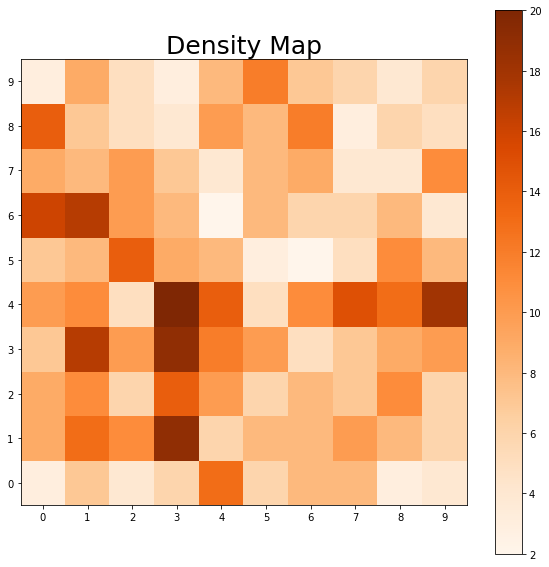

In [67]:
som.plot_density_map(df_train)

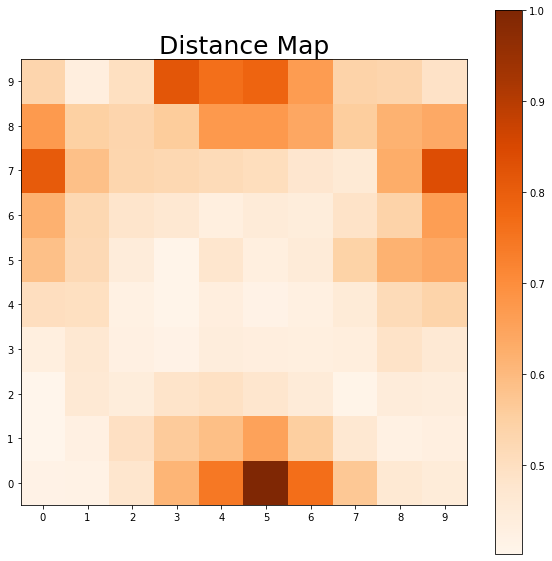

In [69]:
som.plot_distance_map()

In [9]:
bidu_df_train = pd.DataFrame(bidu_df_train, columns=bidu_df_train_columns)
bidu_df_test = pd.DataFrame(bidu_df_test, columns=bidu_df_train_columns)

In [10]:
bidu_df

,Date,Price,High,Low,f1,f2,f3,f4,f5,f6,...,f10,f11,f13,f14,f15,f16,f17,f18,close_plus_20_days,profit
0,2016-01-25,167.54,173.74,167.31,-0.021435,0.009450,0.027322,-0.006284,-0.011985,0.036772,...,-0.030885,-0.048757,1.160364,39.670855,-10.299317,-3.171667,-0.089605,-55.403515,161.02,-6.52
1,2016-01-26,167.08,168.36,162.89,-0.002749,-0.021435,0.009450,0.027322,-0.024184,-0.011985,...,0.018686,-0.012200,0.406242,38.912177,-9.895959,-2.125833,-0.108288,-74.144197,162.75,-4.33
2,2016-01-27,158.27,167.91,157.42,-0.054170,-0.002749,-0.021435,0.009450,-0.056920,-0.024184,...,-0.051421,-0.032735,-2.255545,27.352439,-10.169955,-10.328333,-0.147298,-105.018416,158.22,-0.05
3,2016-01-28,156.94,162.78,154.53,-0.008439,-0.054170,-0.002749,-0.021435,-0.062609,-0.056920,...,0.045731,-0.005689,-2.787242,26.006670,-10.374825,-10.569167,-0.099960,-126.986665,173.80,16.86
4,2016-01-29,163.27,163.64,158.50,0.039542,-0.008439,-0.054170,-0.002749,0.031103,-0.062609,...,0.047981,0.093712,-1.176182,41.746406,-9.912146,-3.120000,-0.047099,-93.717799,173.42,10.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,2020-11-06,144.00,145.36,141.79,0.000417,0.025542,0.045194,0.000447,0.025959,0.070736,...,-0.025126,-0.044777,1.649970,79.631915,3.655420,9.200833,0.114120,224.564105,144.30,0.30
1208,2020-11-09,144.19,148.38,143.06,0.001319,0.000417,0.025542,0.045194,0.001735,0.025959,...,0.000902,-0.024224,0.818091,79.910998,3.991217,8.627500,0.108472,202.522444,144.99,0.80
1209,2020-11-10,143.25,145.44,141.20,-0.006541,0.001319,0.000417,0.025542,-0.005222,0.001735,...,-0.007859,-0.006957,-1.139606,74.113976,4.133836,6.743333,0.062370,135.570391,151.59,8.34
1210,2020-11-11,143.06,143.44,140.68,-0.001327,-0.006541,0.001319,0.000417,-0.007868,-0.005222,...,0.005213,-0.002646,-1.798273,72.880911,4.183308,5.776667,0.076773,101.602768,158.32,15.26


In [11]:
import numpy as np

def som_predict(x):
    """
    Predicting cluster. 
    """
    result = som.winner(np.array(x))
    return 10*result[0] + result[1]

bidu_df_train['cluster'] = bidu_df_train.apply(lambda x: som_predict(x), axis=1)
bidu_df_test['cluster'] = bidu_df_test.apply(lambda x: som_predict(x), axis=1)

In [12]:
final_df_train = bidu_df_train.join(bidu_df[['Date','Price','close_plus_20_days','profit']].iloc[:, :train_len], lsuffix='_org')
final_df_test = bidu_df_test.join(bidu_df[['Date','Price','close_plus_20_days','profit']].iloc[train_len:].reset_index(drop=True), lsuffix='_org')

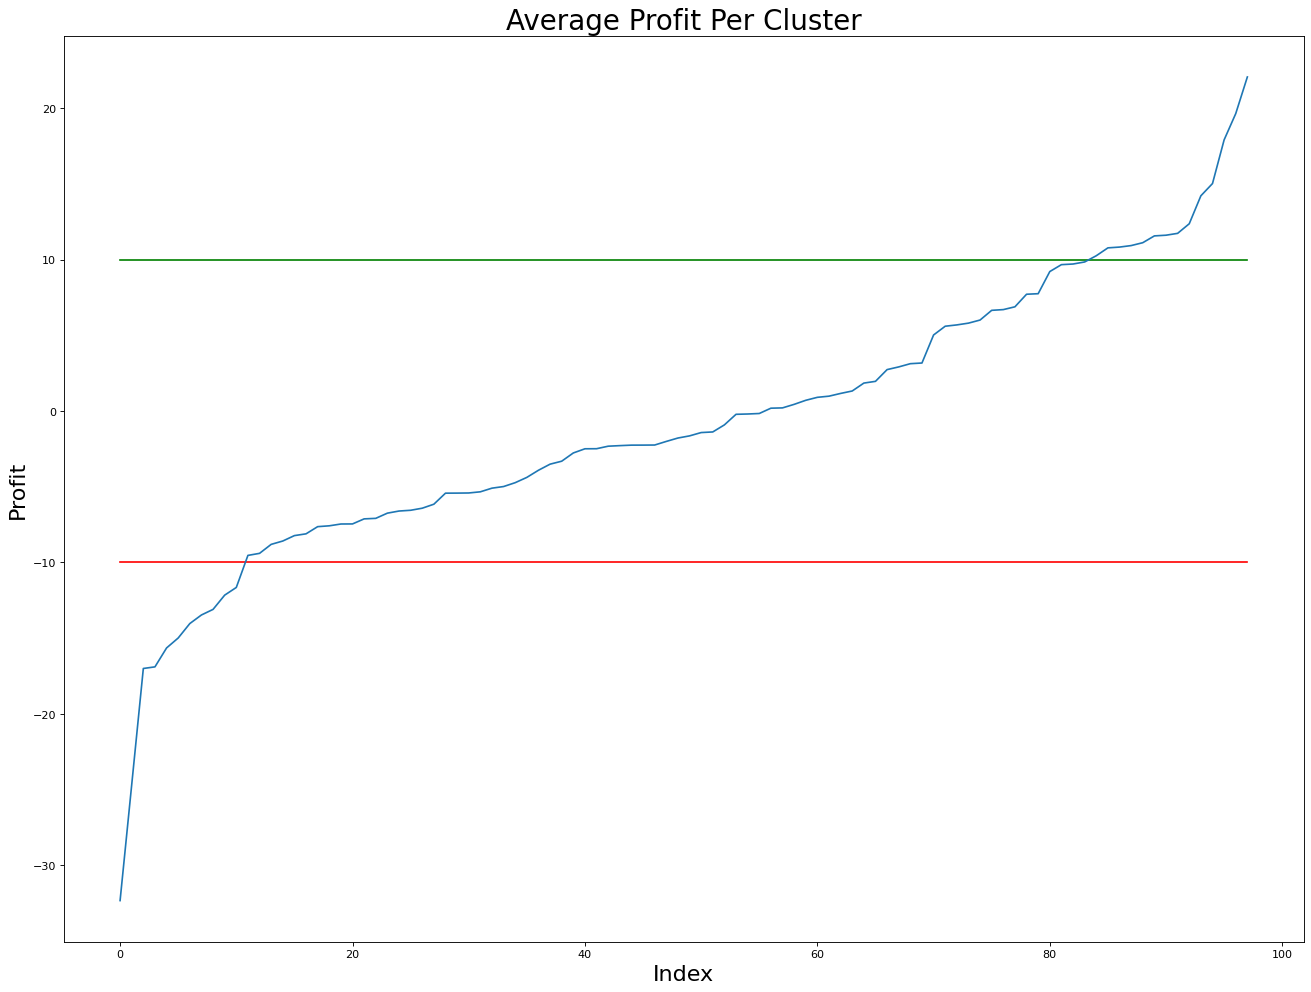

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

x = list(final_df_train.groupby(by='cluster')['profit'].mean().sort_values())
plt.plot([10]*len(x), c='g')
plt.plot([-10]*len(x), c='r')

plt.plot(x)

plt.title("Average Profit Per Cluster", fontsize=25)
plt.ylabel("Profit", fontsize=20)
plt.xlabel("Index", fontsize=20)
plt.show()

according to the 

In [14]:
profit_per_cluster = pd.DataFrame(final_df_train.groupby(by='cluster')['profit'].mean(), columns=['profit']).reset_index()
profit_per_cluster

,cluster,profit
0,0,1.956667
1,1,14.211429
2,2,-1.385000
3,4,-14.993333
4,5,-0.200000
...,...,...
93,95,-6.608333
94,96,-2.492222
95,97,-1.425556
96,98,-2.011000


In [37]:
buy_cluster = list(profit_per_cluster.loc[profit_per_cluster['profit']>10]['cluster'])
sell_cluster = list(profit_per_cluster.loc[profit_per_cluster['profit']<-10]['cluster'])
keep_cluster = list(profit_per_cluster.loc[(profit_per_cluster['profit']<=10) & (profit_per_cluster['profit']>=-10)]['cluster'])

In [38]:
sell_cluster

[4, 22, 41, 50, 51, 52, 53, 61, 71, 72, 82]

In [39]:
# buy
final_df_test.loc[final_df_test['cluster'].isin(buy_cluster)]['profit'].mean(),\
final_df_train.loc[final_df_train['cluster'].isin(buy_cluster)]['profit'].mean()

(1.0742500000000006, 13.162719298245616)

In [40]:
# sell
final_df_test.loc[final_df_test['cluster'].isin(sell_cluster)]['profit'].mean(),\
final_df_train.loc[final_df_train['cluster'].isin(sell_cluster)]['profit'].mean()

(-0.5300000000000011, -16.232444444444443)

In [41]:
# keep
final_df_test.loc[final_df_test['cluster'].isin(keep_cluster)]['profit'].mean(),\
final_df_train.loc[final_df_train['cluster'].isin(keep_cluster)]['profit'].mean()

(1.606068111455108, -1.3260497667185074)

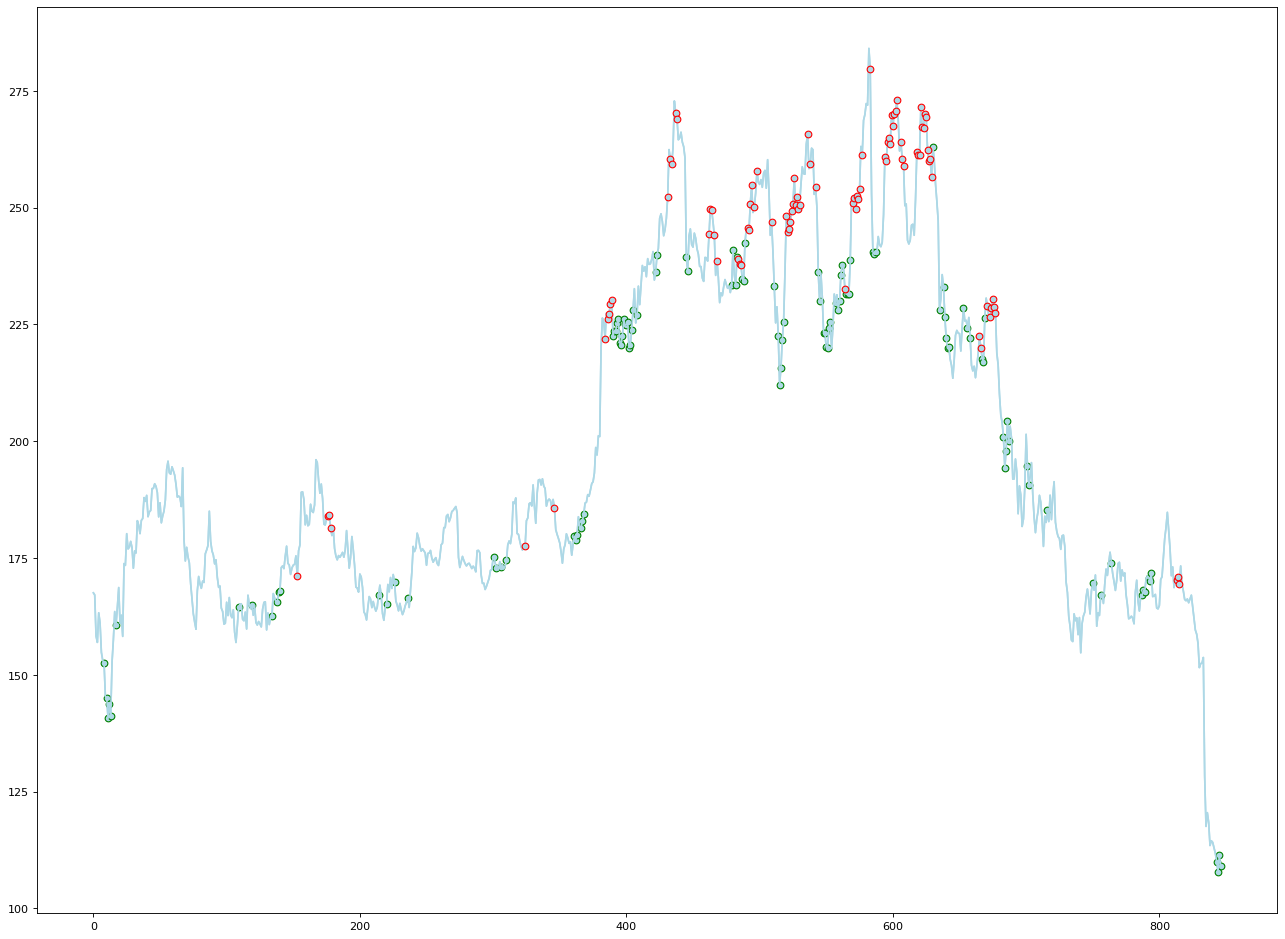

In [43]:
figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(final_df_train['Price'],color='lightblue', marker='o', markeredgecolor='green', markevery=final_df_train.loc[final_df_train['cluster'].isin(buy_cluster)].index)
plt.plot(final_df_train['Price'],color='lightblue', marker='o', markeredgecolor='red', markevery=final_df_train.loc[final_df_train['cluster'].isin(sell_cluster)].index)